# Syllabus :

## In this exercise, you will learn: 
- The idea behind Automated Machine Learning 
    - How TPOT and H2O uses Genetic Programming and Bayesian optimization to select the best machine learning model
    - Limitations of TPOT and H2O
- Using TPOT and H2O for
    - Classification 
    - Regression             *** H2O To Do *** 
    - Model interpretability with autoML - How to incorporate Shap with TPOT and H2O outputs


- How to generate prediction intervals for regression problems     *** TO FINALIZE INTO 1 or 2 Methods Outputs ***

- Comparison of computational and model performance    *** References Provided ***

- What are the key metrics we're going to deliver to our clients and how we can derive them using AutoML
    - Best Model + its parameters
    - Train/Test Statistical Evaluation Metrics
    - Prediction / Prediction Intervals
    - Shap Values

- Using XGBoost/LightGBM/CatBoost for
    - Classification 
    - Regression
    - Model interpretability (standard) - How to incorporate Shap with standard model outputs
    

## In the future  (Suggested)
- How to Deploy AutoML codes as Rest API *** Researching *** 

- More Data is better than trying to find the best MOdel : https://towardsdatascience.com/the-strategy-that-increases-model-accuracy-every-time-guaranteed-6ee5e476262d
- How to handle Larger Datasets (Using Dask) 
- How to perform Automated Feature Engineering (Next Exercise)
    - Using FeatureTools
    - Using tsFresh : https://github.com/blue-yonder/tsfresh
    
    

- References:
    - Tpot: https://www.datacamp.com/community/tutorials/tpot-machine-learning-python
    - Shap: https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a



# Importing Packages For Tutorial

In [2]:
# CALLED BELOW 
from tpot import TPOTClassifier
from tpot import TPOTRegressor

from timeit import default_timer as timer
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectFwe
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from timeit import default_timer as timer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
import shap
shap.initjs()

# AutoML For Classification 
- Example : Breast Cancer Dataset

## Data Preparation

### Reading in breast cancer classification data

In [3]:
cancer = pd.read_csv('breast_cancer.csv')  

In [3]:
cancer.head(5)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

In [5]:
# brief understanding of the data 
print('Rows:', cancer.shape[0])
print('Columns:', cancer.shape[1])
print('Features:\n', cancer.columns.tolist())
print('Missing Values:\n', cancer.isnull().sum().values.sum())


Rows: 569
Columns: 33
Features:
 ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']
Missing Values:
 569


In [4]:
cancer = cancer.drop(columns=['Unnamed: 32'])

## Prediction using TPOT Classifier 

### Before using tpot, it is essential you do the labeling of categorical variables in your DataFrame.

#### Seems like only the diagnosis (target) column is categorical

In [8]:
tpot_cancer = cancer.copy()

tpot_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [15]:
tpot_cancer.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

#### Let's convert the diagnosis column to labels

In [6]:
# LEt's convert the diagnosis column to labels
tpot_cancer.diagnosis = tpot_cancer.diagnosis.map({'B':0,'M':1})

### Check for null values before splitting the dataset 

In [7]:
tpot_cancer.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

### Split the Cancer Dataset into train / test and features/columns

In [8]:
X = tpot_cancer.drop(columns=['id','diagnosis'])
y = tpot_cancer['diagnosis']
X_train,X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state = 7)

From version 0.21, test_size will always complement train_size unless both are specified.


### We will use the TPOT library to suggest us the best pipeline for this binary classification problem.
- To do so, let's import the TPOTClassifier class from the tpot library. Had this been a regression problem you would have imported TPOTRegressor class.

### Choosing TPOTClassifier Parameters:

#### TPOTClassifier has a wide variety of parameters, and you can read all about them here http://epistasislab.github.io/tpot/api/
##### The most notable ones you must know are:

- generations: Number of iterations to the run pipeline optimization process. The default is 100.
population_size: Number of individuals to retain in the genetic programming population every generation. The default is 100.
- offspring_size: Number of offspring to produce in each genetic programming generation. The default is 100.
- mutation_rate: Mutation rate for the genetic programming algorithm in the range [0.0, 1.0]. This parameter tells the GP algorithm how many pipelines to apply random changes to every generation. Default is 0.9
- crossover_rate: Crossover rate for the genetic programming algorithm in the range [0.0, 1.0]. This parameter tells the genetic programming algorithm how many pipelines to "breed" every generation.
- scoring: Function used to evaluate the quality of a given pipeline for the classification problem like accuracy, average_precision, roc_auc, recall, etc. The default is accuracy.
- cv: Cross-validation strategy used when evaluating pipelines. The default is 5.
- random_state: The seed of the pseudo-random number generator used in TPOT. Use this parameter to make sure that TPOT will give you the same results each time you run it against the same data set with that seed.
- Also note mutation_rate + crossover_rate cannot exceed 1.0.

#### EXAMPLE USING 2 SPECIFIED PARAMETERS: 
- Here you will use tpot with generations = 5 and the rest of the parameters at default values. The parameter verbosity = 2 states how much information TPOT communicates while it's running.

- Then you will call the fit() method with the training set (without the target column) and the target column as the arguments.

In [9]:
from tpot import TPOTClassifier

In [10]:
tpot = TPOTClassifier(generations=5,verbosity=2)
start = timer()
tpot.fit(X_train,y_train)
runtime = timer()-start
print(f'Runtime in seconds: {runtime}\n ')


Generation 1 - Current best internal CV score: 0.9724660103141115
Generation 2 - Current best internal CV score: 0.9724660103141115
Generation 3 - Current best internal CV score: 0.9724660103141115
Generation 4 - Current best internal CV score: 0.9724660103141115
Generation 5 - Current best internal CV score: 0.9724660103141115

Best pipeline: GradientBoostingClassifier(CombineDFs(input_matrix, input_matrix), learning_rate=0.5, max_depth=5, max_features=0.7500000000000001, min_samples_leaf=12, min_samples_split=19, n_estimators=100, subsample=0.55)
Runtime in seconds: 325.81393919999994
 


#### In the above, 5 generations were computed, each giving the training efficiency of the fitting model on the training set.

- As evident, the best pipeline is the one that has the CV accuracy score of 88.16%. 
- The model that produces this result is the pipeline, consisting of pre-processing techniques like PloynomialFeatures and then RobustScaler that adds synthetic features to the input data and normalizes them, which then get utilized by a Gradient Boosting classifier to form the final predictions. 
- You can also notice that tpot gives various hyper-parameter values like learning_rate,max_depth, etc., also along with the classifier.



### Next, the test error is computed for validation purposes.
- As can be seen, the test accuracy is ~97%.


In [24]:
tpot.score(X_test,
           y_test)

0.9707602339181286

### Finally, you can tell TPOT to export the corresponding Python code for the optimized pipeline to a text file with the export function

- Without you tweaking a lot of parameters and options to get the best model, TPOT not only gave you the information about the best model but also a working code for it!

In [ ]:
tpot.export('tpot_breast_cancer_pipeline.py')

### Controlling the Execution Time of TPOT (To suit time constraints of Data Scientists)


#### There are certain parameters you can specify to control the execution time of TPOT but WITH A TRADE OFF! 
#####   Trade Off: Since you will be limiting the time of TPOT execution, TPOT won't be able to explore all the possible pipelines and hence the best model suggested by TPOT at the end of the constrained time limit may not be the best model possible for that dataset. However, if sufficient time is given it will be somewhat closer to the best possible model. 



- Some parameters are:

    - max_time_mins: how many minutes TPOT has to optimize the pipeline. If not None, this setting will override the generations parameter and allow TPOT to run until max_time_mins minutes elapse.
    - max_eval_time_mins: how many minutes TPOT has to evaluate a single pipeline. Setting this parameter to higher values will enable TPOT to evaluate more complex pipelines, but will also allow TPOT to run longer. Use this parameter to help prevent TPOT from wasting time on assessing time-consuming pipelines. The default is 5.
    - early_stop: how many generations TPOT checks whether there is no improvement in the optimization process. Ends the optimization process if there is no improvement in the given number of generations.
    - n_jobs: Number of procedures to use in parallel for evaluating pipelines during the TPOT optimization process. Setting n_jobs=-1 will use as many cores as available on the computer. Beware that using multiple methods on the same machine may cause memory issues for large datasets. The default is 1.
    - subsample: Fraction of training samples that are used during the TPOT optimization process. Must be in the range (0.0, 1.0]. The default is 1.

### Just for practice, you will again run TPOT with additional arguments max_time_mins = 2 and max_eval_time_mins = 0.04 but this time with reduced population_size = 15.

- As you can notice the best performing classifier within the time frame specified is now XGBoost with SelectPercentile() and RobustScaler() as the pre-processing steps.


In [16]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=2, max_eval_time_mins=0.04, population_size=15)
tpot.fit(X_train,y_train)

Generation 1 - Current best internal CV score: 0.9598394280356304
Generation 2 - Current best internal CV score: 0.9623710736052506
Generation 3 - Current best internal CV score: 0.9623710736052506
Generation 4 - Current best internal CV score: 0.9623710736052506
Generation 5 - Current best internal CV score: 0.9649027191748709
Generation 6 - Current best internal CV score: 0.9649027191748709
Generation 7 - Current best internal CV score: 0.9649027191748709
Generation 8 - Current best internal CV score: 0.9649027191748709
Generation 9 - Current best internal CV score: 0.9649027191748709
Generation 10 - Current best internal CV score: 0.9649027191748709
Generation 11 - Current best internal CV score: 0.9674660103141115
Generation 12 - Current best internal CV score: 0.9674660103141115
Generation 13 - Current best internal CV score: 0.9674660103141115
Generation 14 - Current best internal CV score: 0.9674660103141115
Generation 15 - Current best internal CV score: 0.9698402094077199
Gene

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=1000000,
        max_eval_time_mins=0.04, max_time_mins=2, memory=None,
        mutation_rate=0.9, n_jobs=1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=15,
        random_state=None, scoring=None, subsample=1.0, template=None,
        use_dask=False, verbosity=2, warm_start=False)

In [18]:
best_model_2_mins = tpot.fitted_pipeline_.steps[-1][1]

### Wrapping it all up into a single Classification Method
- Here we simply place all the metrics of interest into a single tpotClassification method which will 
    - train (fit) and return the best model
    - return predictions
    - return the training and validation scores
    - print a confusion matrix
    - identify the best pipeline and export the optimized pipeline as python code.

In [11]:
# Current Parameters set to default values 
def tpotClassification(exported_pipeline_name,X_train,y_train,X_test,y_test,gen=1000000,mr=0.9,cr=0.1,
                       scoring_metric='roc_auc',cv=5,verbosity=2,max_time_mins=None, max_eval_time_mins=5,
                       population_size=100):
    
    # Defining the classifier    
    tpot = TPOTClassifier(generations=gen,mutation_rate=mr,crossover_rate=cr,
                          scoring=scoring_metric,cv=cv,verbosity=verbosity,max_time_mins=max_time_mins,
                          max_eval_time_mins=max_eval_time_mins,
                       population_size=population_size)
    print(tpot)
    
    # Training the Classifier
    start = timer()
    tpot.fit(X_train,y_train)
    runtime = timer()-start
    print(f'Runtime in seconds: {runtime}\n ')
    
    # generating Predictions
    predictions = tpot.predict(X_test)
    
    # printing Training Score
    training_score = tpot.score(X_train,y_train)
    print(f"Train {scoring_metric} score:{training_score}\n")
    
    # printing Validation(Test) Score
    validation_score = tpot.score(X_test,y_test)
    print(f"Test {scoring_metric} score:{validation_score}\n")
    
    # printing confusion matrix 
    cf = confusion_matrix(y_test, predictions)
    print(cf)
    
    # Get the best model
    extracted_best_model = tpot.fitted_pipeline_.steps[-1][1]

    print(extracted_best_model)
    
    # Export optimized pipeline as Python code.
    tpot.export(f'{exported_pipeline_name}.py')
    
    # Return predictions,training_score,validation_score 
    return extracted_best_model, predictions,training_score,validation_score




In [12]:
best_model,predictions,train_score,valid_score =  tpotClassification('tpot_breast_cancer_',X_train,y_train,X_test,y_test,gen=5)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=5,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=100,
        random_state=None, scoring='roc_auc', subsample=1.0, template=None,
        use_dask=False, verbosity=2, warm_start=False)


Generation 1 - Current best internal CV score: 0.9937121975806452
Generation 2 - Current best internal CV score: 0.9937121975806452
Generation 3 - Current best internal CV score: 0.9937121975806452
Generation 4 - Current best internal CV score: 0.9937121975806452
Generation 5 - Current best internal CV score: 0.9937121975806452

Best pipeline: LogisticRegression(MinMaxScaler(SelectFwe(input_matrix, alpha=0.017)), C=5.0, dual=False, penalty=l2)
Runtime in seconds: 263.6201805999999
 
Train roc_auc score:0.9954013267436636

Test roc_auc score:0.9934169278996866

[[116   0]
 [  6  49]]
LogisticRegression(C=5.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


### Based on the results, we can tell that 
1) TPOT took 227 seconds i.e. 3.78 minutes of training time to converge to a final model 
2) The best pipeline included 
    - Converting all the input features into Polynomial features with degre 2 
    - Usage of an XG Boost Classifier with learning rate 0.01 , max_depth=10, n_estimators=100 etc.
3) The Test ROC_AUC Score was pretty good at 0.985, close to 1. It did lose out slightly to H2O which converged to 0.993366 ROC_AUC score

### Exported Pipeline Code:

#### For XGBoost:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBClassifier

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:0.9935223282861532
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    XGBClassifier(learning_rate=0.01, max_depth=10, min_child_weight=18, n_estimators=100, nthread=1, subsample=0.45)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


#### For Logistic Regression:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFwe, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:0.9937121975806452
exported_pipeline = make_pipeline(
    SelectFwe(score_func=f_classif, alpha=0.017),
    MinMaxScaler(),
    LogisticRegression(C=5.0, dual=False, penalty="l2")
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


#### From here we can see that TPOT actually built a pipeline that included 
- a preprocessing step (converting all features into a polynomial features with degree 2  and 
- selected XG Boost Classifier as the best model

### Limitations


#### TPOT can take a long time to finish its search
- Running TPOT isn’t as simple as fitting one model on the dataset. It is considering multiple machine learning algorithms (random forests, linear models, SVMs, etc.) in a pipeline with numerous preprocessing steps (missing value imputation, scaling, PCA, feature selection, etc.), the hyper-parameters for all of the models and preprocessing steps, as well as multiple ways to ensemble or stack the algorithms within the pipeline. That’s why it usually takes a long time to execute and isn’t feasible for large datasets.

#### TPOT can recommend different solutions for the same dataset
- If you're working with a reasonably complex dataset or run TPOT for a short amount of time, different TPOT runs may result in different pipeline recommendations. When two TPOT runs recommend different pipelines, this means that the TPOT runs didn't converge due to lack of time or that multiple pipelines perform more-or-less the same on your dataset.

#####  An Example of this is seen below when running the above TPOT Classifier for Breast Cancer: 


![image.png](attachment:image.png)

## Prediction using H2O Classifier

In [ ]:
# Load Libraries 

import h2o
from h2o.automl import H2OAutoML
from timeit import default_timer as timer
from datetime import timedelta

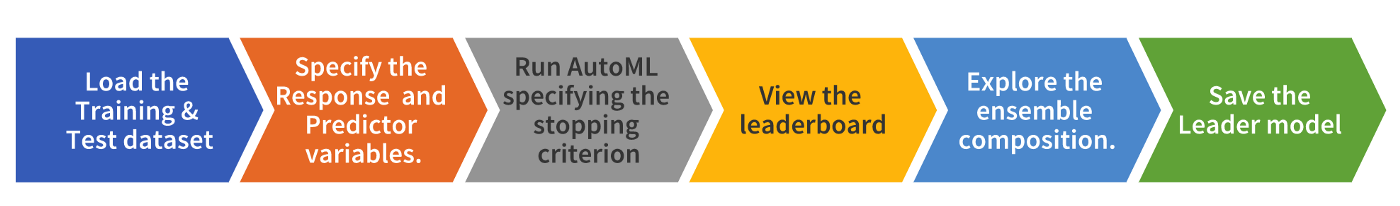

#### Initialize h2O cluster instance 

In [46]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------------
H2O cluster uptime:         3 hours 43 mins
H2O cluster timezone:       Asia/Singapore
H2O data parsing timezone:  UTC
H2O cluster version:        3.28.0.3
H2O cluster version age:    2 months
H2O cluster name:           H2O_from_python_ranon_850f2g
H2O cluster total nodes:    1
H2O cluster free memory:    6.733 Gb
H2O cluster total cores:    16
H2O cluster allowed cores:  16
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:       {'http': None, 'https': None}
H2O internal security:      False
H2O API Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.7.1 final
--------------------------  ---------------------------------------------------------

In [48]:
# brief understanding of the data 
print('Rows:', cancer.shape[0])
print('Columns:', cancer.shape[1])
print('Features:\n', cancer.columns.tolist())
print('Missing Values:\n', cancer.isnull().sum().values.sum())


Rows: 569
Columns: 32
Features:
 ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Missing Values:
 0


#### Split Data into Train and validation 

In [49]:
h2o_cancer = cancer.copy()
X = h2o_cancer.drop(columns=['id','diagnosis'])
y = h2o_cancer['diagnosis']
X_train,X_test, y_train, y_test = train_test_split(X,y,train_size = 0.8, random_state = 7)


From version 0.21, test_size will always complement train_size unless both are specified.


#### Load Data into H2O 
- Normally H2O can take in various python objects including: 
    - list | tuple | dict | numpy.ndarray | pandas.DataFrame | scipy.sparse.issparse
- Loading Data into H2O can involve
    - using H2O's import_file(<data_path>) fn to read in a CSV file
    - using H2OFrame() function to read in a Python object as a H2O Data frame

In [50]:
# Convert train data into a python object acceptable by H2O 
# i.e. list | tuple | dict | numpy.ndarray | pandas.DataFrame | scipy.sparse.issparse
y_train = y_train.to_frame()
y_test = y_test.to_frame()


start = timer()

train_h2o_df = h2o.H2OFrame(X_train)
train_h2o_df['labels'] = h2o.H2OFrame(y_train)
train_h2o_df['labels'] = train_h2o_df['labels'].asfactor()
test_h2o_df = h2o.H2OFrame(X_test)
test_h2o_df['labels'] = h2o.H2OFrame(y_test)
test_h2o_df['labels'] = test_h2o_df['labels'].asfactor()



# runtime = -start
print(timedelta(seconds=timer()-start))

# print(runtime)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
0:00:40.181349


#### Train, Generate Leaderboard and Predict

In [33]:
def automl(train,test,feature_names,target,max_models=None,max_runtime_secs=0):
    start = timer()
    
    #Specify Parameters e.g. Stopping Parameters
    aml = H2OAutoML(max_models=max_models, max_runtime_secs=max_runtime_secs)
    #train the model 
    aml.train(x=feature_names,y= target, training_frame=train)
    
    run_time = timer()-start
    print(run_time)
    
    #View the AutoML Leaderboard
    lb = aml.leaderboard
    print(lb)
    
    #Predict model
    pred = aml.predict(test)
    print(pred)
    h20_predictions_df = pred.as_data_frame()
    print("H2O: " + str(accuracy_score(test[target].as_data_frame(), h20_predictions_df.predict)))
    # use confusion matrix if it is classification problem
    cf = confusion_matrix(test[target].as_data_frame(), h20_predictions_df.predict)
    print(cf)
    return aml

In [30]:
feature_names = list(X_train.columns)

In [34]:
aml = automl(train_h2o_df,test_h2o_df,feature_names,"labels",None,120)

AutoML progress: |
12:00:30.461: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████

Exception ignored in: <function ExprNode.__del__ at 0x000001BFCD0F36A8>
Traceback (most recent call last):
  File "C:\Users\ranon\Anaconda3\lib\site-packages\h2o\expr.py", line 187, in __del__
    ExprNode.rapids("(rm {})".format(self._cache._id))
  File "C:\Users\ranon\Anaconda3\lib\site-packages\h2o\expr.py", line 241, in rapids
    return h2o.api("POST /99/Rapids", data={"ast": expr, "session_id": h2o.connection().session_id})
  File "C:\Users\ranon\Anaconda3\lib\site-packages\h2o\h2o.py", line 123, in api
    return h2oconn.request(endpoint, data=data, json=json, filename=filename, save_to=save_to)
  File "C:\Users\ranon\Anaconda3\lib\site-packages\h2o\backend\connection.py", line 474, in request
    auth=self._auth, verify=verify, proxies=self._proxies)
  File "C:\Users\ranon\Anaconda3\lib\site-packages\requests\api.py", line 60, in request
    return session.request(method=method, url=url, **kwargs)
  File "C:\Users\ranon\Anaconda3\lib\site-packages\requests\sessions.py", line 53

| 100%
2720.1756071000054


model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 DeepLearning_grid__2_AutoML_20200406_120030_model_11 0.996097 0.0760607 0.506554 0.0163017 0.120847 0.0146041 
 DeepLearning_grid__3_AutoML_20200406_120030_model_13 0.996056 0.0893485 0.349449 0.0203488 0.136871 0.0187337 
 DeepLearning_grid__3_AutoML_20200406_120030_model_5 0.995337 0.0835776 0.435949 0.0261628 0.141725 0.0200859 
 DeepLearning_grid__1_AutoML_20200406_120030_model_25 0.995295 0.0932751 0.383933 0.0238824 0.135118 0.0182569 
 DeepLearning_grid__1_AutoML_20200406_120030_model_27 0.995234 0.09737 0.296314 0.0250226 0.135143 0.0182637 
 DeepLearning_grid__1_AutoML_20200406_120030_model_34 0.995213 0.0825625 0.413071 0.0180685 0.128902 0.0166158 
 DeepLearning_grid__1_AutoML_20200406_120030_model_6 0.995111 0.0816765 0.487973 0.0256492 0.140464 0.0197301 
 DeepLearning_grid__2_AutoML_20200406_120030_model_8 0.994926 0.100587 0.371488 0.0319767 0.164904 0.0271933 
 DeepLearning_grid__1_AutoML_20200406_120030_model_1 0.994905 0.0986482 0.354213 0.0267894 0.140931 0.0198616 
 DeepLearning_grid__1_AutoML_20200406_120030_model_15 0.994823 0.0966761 0.342725 0.0250226 0.139606 0.01949


deeplearning prediction progress: |███████████████████████████████████████| 100%


predict B M 
 
 
 B 0.999999 6.52918e-07 
 M 8.87815e-12 1 
 B 0.999998 2.39319e-06 
 B 1 1.23021e-08 
 B 0.972719 0.0272814 
 M 3.91253e-09 1 
 B 0.999999 7.35406e-07 
 B 1 7.31535e-08 
 M 0.00987723 0.990123 
 B 0.999998 2.0327e-06


H2O: 1.0
[[74  0]
 [ 0 40]]


#### Save Leaderboard

In [ ]:
h2o.save_model(aml.leader, path="./leaderboard")

## AutoML model interpretability



### Here we will interpret the best model in the following ways:
####  1) Feature Importance
#### 2) Model Parameters
#### 3) Shap values 

### With H2O

#### View the Variable importance & Parameters of the Best Model

In [13]:
bst_model = aml.leader

In [14]:
bst_model.get_params

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20200316_234258


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               79.0                      79.0              20913.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        4.0        7.0    6.936709         7.0        22.0    16.443037



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 4.641225698934361e-05
RMSE: 0.0068126541809594016
LogLoss: 0.0028185172201535013
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 0.9936305732484076
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9347508458891651: 


B      M Error          Rate
0      B  241.0    0.0   0.0   (0.0/241.0)
1      M    0.0  157.0   0.0   (0.0/157.0)
2  Total  241.0  157.0   0.0   (0.0/398.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.934751    1.000000  156.0
1                        max f2   0.934751    1.000000  156.0
2                  max f0point5   0.934751    1.000000  156.0
3                  max accuracy   0.934751    1.000000  156.0
4                 max precision   0.999755    1.000000    0.0
5                    max recall   0.934751    1.000000  156.0
6               max specificity   0.999755    1.000000    0.0
7              max absolute_mcc   0.934751    1.000000  156.0
8    max min_per_class_accuracy   0.934751    1.000000  156.0
9   max mean_per_class_accuracy   0.934751    1.000000  156.0
10                      max tns   0.999755  241.000000    0.0
11                      max fns   0.999755  156.000000    0.0
12                      max fps   0.000167  241.000000  397.0
13                      max tps   0.934751  157.000000  156.0
14                      max tnr   0.999755    1.000000    0.0
15                      max fnr   0.999755    0.993631    0.0
16                      max fpr   0.000167    1.000000  397.0
17                      max tpr   0.934751    1.000000  156.0


Gains/Lift Table: Avg response rate: 39.45 %, avg score: 39.43 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010050         0.999702  2.535032   
1         2                  0.020101         0.999685  2.535032   
2         3                  0.030151         0.999676  2.535032   
3         4                  0.040201         0.999653  2.535032   
4         5                  0.050251         0.999642  2.535032   
5         6                  0.100503         0.999581  2.535032   
6         7                  0.150754         0.999465  2.535032   
7         8                  0.201005         0.999215  2.535032   
8         9                  0.301508         0.997330  2.535032   
9        10                  0.399497         0.018145  2.405030   
10       11                  0.500000         0.003195  0.000000   
11       12                  0.600503         0.000927  0.000000   
12       13                  0.698492         0.000621  0.000000   
13       14                  0.798995         0.000408  0.000000   
14       15                  0.899497         0.000302  0.000000   
15       16                  1.000000         0.000167  0.000000   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.535032       1.000000  0.999734                  1.000000   
1          2.535032       1.000000  0.999695                  1.000000   
2          2.535032       1.000000  0.999682                  1.000000   
3          2.535032       1.000000  0.999668                  1.000000   
4          2.535032       1.000000  0.999649                  1.000000   
5          2.535032       1.000000  0.999612                  1.000000   
6          2.535032       1.000000  0.999525                  1.000000   
7          2.535032       1.000000  0.999361                  1.000000   
8          2.535032       1.000000  0.998681                  1.000000   
9          2.503145       0.948718  0.937356                  0.987421   
10         2.000000       0.000000  0.008189                  0.788945   
11         1.665272       0.000000  0.001799                  0.656904   
12         1.431655       0.000000  0.000760                  0.564748   
13         1.251572       0.000000  0.000507                  0.493711   
14         1.111732       0.000000  0.000352                  0.438547   
15         1.000000       0.000000  0.000248                  0.394472   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.999734      0.025478                 0.025478  153.503185   
1           0.999714      0.025478                 0.050955  153.503185   
2           0.999703      0.025478                 0.076433  153.503185   
3           0.999695      0.025478                 0.101911  153.503185   
4           0.999685      0.025478                 0.127389  153.503185   
5           0.999649      0.127389                 0.254777  153.503185   
6           0.999607      0.127389                 0.382166  153.503185   
7           0.999546      0.127389                 0.509554  153.503185   
8           0.999257      0.254777                 0.764331  153.503185   
9           0.984074      0.235669                 1.000000  140.503021   
10          0.787916      0.000000                 1.000000 -100.000000   
11          0.656348      0.000000                 1.000000 -100.000000   
12          0.564377      0.000000                 1.000000 -100.000000   
13          0.493450      0.000000                 1.000000 -100.000000   
14          0.438355      0.000000                 1.000000 -100.000000   
15          0.394325      0.000000                 1.000000 -100.000000   

    cumulative_gain  
0        153.503185  
1        153.503185  
2        153.503185  
3        153.503185  
4        153.503185  
5        153.503185  
6        153.503185  
7        153.503185  
8        153.503185  
9        150.314465  
10       100.000000  
11        66.527197  
12        43.165468  
13    



ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.023858899107260023
RMSE: 0.1544632613512353
LogLoss: 0.0891933436752685
Mean Per-Class Error: 0.02948172423817952
AUC: 0.9933662816819515
AUCPR: 0.9860181477343235
Gini: 0.986732563363903

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4468106872820841: 


B      M   Error           Rate
0      B  236.0    5.0  0.0207    (5.0/241.0)
1      M    6.0  151.0  0.0382    (6.0/157.0)
2  Total  242.0  156.0  0.0276   (11.0/398.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.446811    0.964856  153.0
1                        max f2   0.100934    0.969962  168.0
2                  max f0point5   0.847407    0.978408  143.0
3                  max accuracy   0.525807    0.972362  151.0
4                 max precision   0.999979    1.000000    0.0
5                    max recall   0.001424    1.000000  270.0
6               max specificity   0.999979    1.000000    0.0
7              max absolute_mcc   0.446811    0.942095  153.0
8    max min_per_class_accuracy   0.446811    0.961783  153.0
9   max mean_per_class_accuracy   0.446811    0.970518  153.0
10                      max tns   0.999979  241.000000    0.0
11                      max fns   0.999979  156.000000    0.0
12                      max fps   0.000008  241.000000  395.0
13                      max tps   0.001424  157.000000  270.0
14                      max tnr   0.999979    1.000000    0.0
15                      max fnr   0.999979    0.993631    0.0
16                      max fpr   0.000008    1.000000  395.0
17                      max tpr   0.001424    1.000000  270.0


Gains/Lift Table: Avg response rate: 39.45 %, avg score: 39.11 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010050         0.999974  2.535032   
1         2                  0.020101         0.999945  2.535032   
2         3                  0.030151         0.999911  2.535032   
3         4                  0.040201         0.999715  2.535032   
4         5                  0.050251         0.999682  2.535032   
5         6                  0.100503         0.999476  2.535032   
6         7                  0.150754         0.999235  2.535032   
7         8                  0.201005         0.998106  2.535032   
8         9                  0.301508         0.991034  2.535032   
9        10                  0.399497         0.321808  2.015025   
10       11                  0.500000         0.008364  0.253503   
11       12                  0.600503         0.002423  0.063376   
12       13                  0.698492         0.001108  0.065001   
13       14                  0.798995         0.000473  0.000000   
14       15                  0.899497         0.000231  0.000000   
15       16                  1.000000         0.000008  0.000000   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.535032       1.000000  0.999977                  1.000000   
1          2.535032       1.000000  0.999965                  1.000000   
2          2.535032       1.000000  0.999929                  1.000000   
3          2.535032       1.000000  0.999842                  1.000000   
4          2.535032       1.000000  0.999704                  1.000000   
5          2.535032       1.000000  0.999585                  1.000000   
6          2.535032       1.000000  0.999339                  1.000000   
7          2.535032       1.000000  0.998877                  1.000000   
8          2.535032       1.000000  0.995868                  1.000000   
9          2.407483       0.794872  0.830280                  0.949686   
10         1.974522       0.100000  0.080358                  0.778894   
11         1.654665       0.025000  0.004440                  0.652720   
12         1.431655       0.025641  0.001719                  0.564748   
13         1.251572       0.000000  0.000719                  0.493711   
14         1.111732       0.000000  0.000350                  0.438547   
15         1.000000       0.000000  0.000084                  0.394472   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.999977      0.025478                 0.025478  153.503185   
1           0.999971      0.025478                 0.050955  153.503185   
2           0.999957      0.025478                 0.076433  153.503185   
3           0.999928      0.025478                 0.101911  153.503185   
4           0.999883      0.025478                 0.127389  153.503185   
5           0.999734      0.127389                 0.254777  153.503185   
6           0.999603      0.127389                 0.382166  153.503185   
7           0.999421      0.127389                 0.509554  153.503185   
8           0.998237      0.254777                 0.764331  153.503185   
9           0.957040      0.197452                 0.961783  101.502531   
10          0.780822      0.025478                 0.987261  -74.649682   
11          0.650884      0.006369                 0.993631  -93.662420   
12          0.559814      0.006369                 1.000000  -93.499918   
13          0.489487      0.000000                 1.000000 -100.000000   
14          0.434835      0.000000                 1.000000 -100.000000   
15          0.391142      0.000000                 1.000000 -100.000000   

    cumulative_gain  
0        153.503185  
1        153.503185  
2        153.503185  
3        153.503185  
4        153.503185  
5        153.503185  
6        153.503185  
7        153.503185  
8        153.503185  
9        140.748307  
10        97.452229  
11        65.466514  
12        43.165468  
13    



Cross-Validation Metrics Summary: 


mean           sd  cv_1_valid  \
0                  accuracy    0.9798734  0.011340313      0.9875   
1                       auc     0.991977  0.008519099  0.97863245   
2                     aucpr     0.959121  0.010482885   0.9407467   
3                       err  0.020126583  0.011340313      0.0125   
4                 err_count          1.6    0.8944272         1.0   
5                  f0point5     0.976133  0.016821718  0.99206346   
6                        f1    0.9754125  0.010664006  0.98039216   
7                        f2   0.97496945  0.016781913  0.96899223   
8            lift_top_group    2.5702708   0.34537476   3.0769231   
9                   logloss   0.08920263   0.04674228  0.12354814   
10      max_per_class_error   0.03784709  0.012196644  0.03846154   
11                      mcc    0.9586242  0.021804225   0.9716254   
12  mean_per_class_accuracy    0.9786955  0.010666265   0.9807692   
13     mean_per_class_error  0.021304497  0.010666265  0.01923077   
14                      mse  0.023861026  0.010754909   0.0248746   
15                   pr_auc     0.959121  0.010482885   0.9407467   
16                precision    0.9767659  0.024053847         1.0   
17                       r2   0.89962274  0.042950567   0.8866115   
18                   recall    0.9748302    0.0242108  0.96153843   
19                     rmse   0.15104619   0.03616065  0.15771684   

     cv_2_valid   cv_3_valid   cv_4_valid   cv_5_valid  
0         0.975       0.9875   0.98734176   0.96202534  
1     0.9941973   0.99866664   0.99932796   0.98906046  
2     0.9613131    0.9645497    0.9667176    0.9622778  
3         0.025       0.0125  0.012658228   0.03797468  
4           2.0          1.0          1.0          3.0  
5     0.9537572    0.9931507    0.9748428    0.9668508  
6     0.9705882    0.9830508     0.984127    0.9589041  
7    0.98802394   0.97315437   0.99358976   0.95108694  
8     2.4242425    2.6666667     2.548387    2.1351352  
9    0.08835411  0.052010704   0.03551198    0.1465882  
10   0.04255319  0.033333335  0.020833334  0.054054055  
11   0.95012397    0.9735052    0.9739444   0.92392176  
12    0.9787234   0.98333335    0.9895833    0.9610682  
13  0.021276595  0.016666668  0.010416667   0.03893179  
14  0.029306827   0.01655527  0.010531835  0.038036596  
15    0.9613131    0.9645497    0.9667176    0.9622778  
16   0.94285715          1.0      0.96875    0.9722222  
17    0.8790692    0.9293642    0.9558272    0.8472417  
18          1.0   0.96666664          1.0    0.9459459  
19   0.17119236   0.12866728   0.10262473   0.19502974


See the whole table with table.as_data_frame()

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-03-16 23:43:03   1.385 sec              0.0       0.488737   
1     2020-03-16 23:43:03   1.399 sec              5.0       0.323959   
2     2020-03-16 23:43:03   1.446 sec             10.0       0.224236   
3     2020-03-16 23:43:03   1.461 sec             15.0       0.169841   
4     2020-03-16 23:43:03   1.505 sec             20.0       0.133205   
5     2020-03-16 23:43:03   1.518 sec             25.0       0.107635   
6     2020-03-16 23:43:03   1.530 sec             30.0       0.085315   
7     2020-03-16 23:43:03   1.544 sec             35.0       0.068260   
8     2020-03-16 23:43:03   1.557 sec             40.0       0.054355   
9     2020-03-16 23:43:03   1.569 sec             45.0       0.044845   
10    2020-03-16 23:43:03   1.583 sec             50.0       0.036293   
11    2020-03-16 23:43:03   1.596 sec             55.0       0.028237   
12    2020-03-16 23:43:03   1.608 sec             60.0       0.021247   
13    2020-03-16 23:43:03   1.622 sec             65.0       0.016641   
14    2020-03-16 23:43:03   1.644 sec             70.0       0.011970   
15    2020-03-16 23:43:03   1.658 sec             75.0       0.008527   
16    2020-03-16 23:43:03   1.670 sec             79.0       0.006813   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.670707      0.500000         0.000000       1.000000   
1           0.383313      0.995547         0.987948       2.535032   
2           0.239395      0.998520         0.985198       2.535032   
3           0.162695      0.999181         0.992419       2.535032   
4           0.113489      0.999551         0.992962       2.535032   
5           0.081134      0.999841         0.993391       2.535032   
6           0.057340      1.000000         0.993631       2.535032   
7           0.041199      1.000000         0.993631       2.535032   
8           0.029880      1.000000         0.993631       2.535032   
9           0.022318      1.000000         0.993631       2.535032   
10          0.016449      1.000000         0.993631       2.535032   
11          0.011947      1.000000         0.993631       2.535032   
12          0.008939      1.000000         0.993631       2.535032   
13          0.006556      1.000000         0.993631       2.535032   
14          0.004799      1.000000         0.993631       2.535032   
15          0.003560      1.000000         0.993631       2.535032   
16          0.002819      1.000000         0.993631       2.535032   

    training_classification_error  
0                        0.605528  
1                        0.025126  
2                        0.015075  
3                        0.012563  
4                        0.007538  
5                        0.005025  
6                        0.000000  
7                        0.000000  
8                        0.000000  
9                        0.000000  
10                       0.000000  
11                       0.000000  
12                       0.000000  
13                       0.000000  
14                       0.000000  
15                       0.000000  
16                       0.000000


Variable Importances: 


variable  relative_importance  scaled_importance  \
0           perimeter_worst           202.885513           1.000000   
1       concave points_mean            65.668129           0.323671   
2              radius_worst            63.240803           0.311707   
3      concave points_worst            53.170864           0.262073   
4                area_worst            25.768105           0.127008   
5            concavity_mean            25.744236           0.126890   
6              texture_mean             9.471834           0.046686   
7               radius_mean             4.137645           0.020394   
8           concavity_worst             4.099471           0.020206   
9             texture_worst             3.760479           0.018535   
10           symmetry_worst             3.046944           0.015018   
11         smoothness_worst             2.748013           0.013545   
12     fractal_dimension_se             2.405964           0.011859   
13                  area_se             2.122718           0.010463   
14          smoothness_mean             1.749700           0.008624   
15                radius_se             1.283405           0.006326   
16           perimeter_mean             1.283257           0.006325   
17         compactness_mean             1.227421           0.006050   
18   fractal_dimension_mean             0.896070           0.004417   
19  fractal_dimension_worst             0.889456           0.004384   

    percentage  
0     0.422952  
1     0.136897  
2     0.131837  
3     0.110844  
4     0.053718  
5     0.053669  
6     0.019746  
7     0.008626  
8     0.008546  
9     0.007839  
10    0.006352  
11    0.005729  
12    0.005016  
13    0.004425  
14    0.003648  
15    0.002675  
16    0.002675  
17    0.002559  
18    0.001868  
19    0.001854


See the whole table with table.as_data_frame()


<bound method H2OEstimator.get_params of >

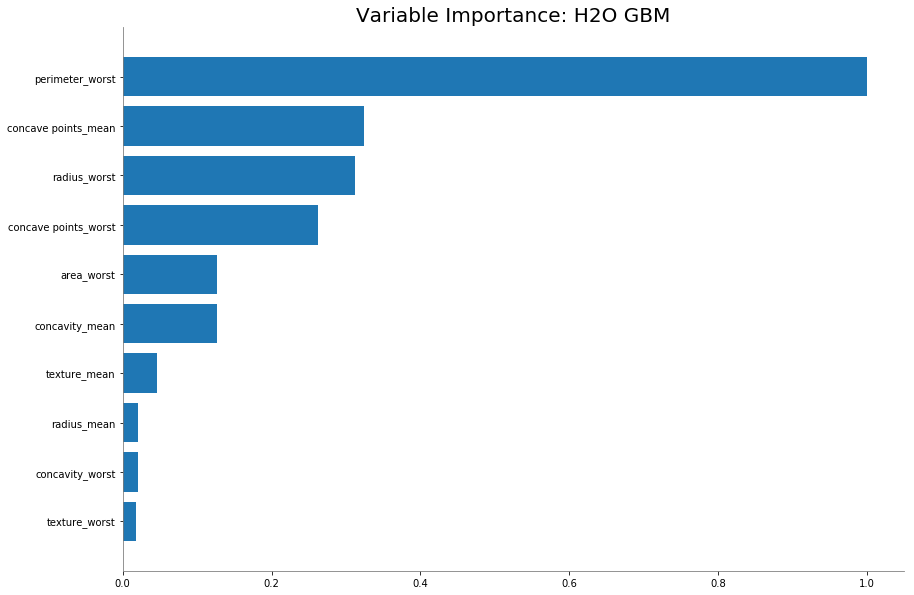

In [15]:
bst_model.varimp_plot()

#### View the Variable importance & Parameters of a Specific Model

In [19]:
m = h2o.get_model("GLM_1_AutoML_20200316_234258")

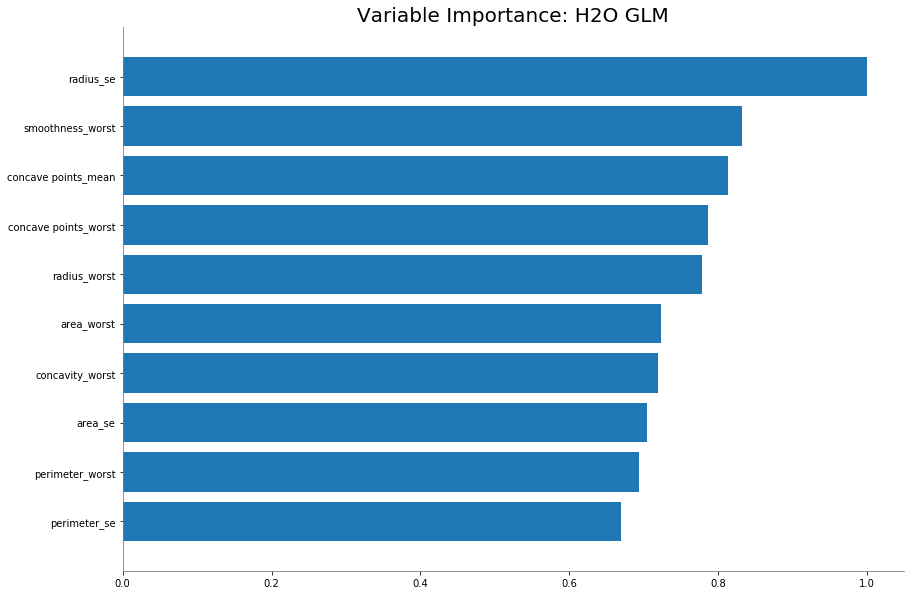

In [20]:
m.varimp_plot()

In [21]:
m.get_params

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_1_AutoML_20200316_234258


GLM Model: summary


family   link               regularization  \
0    binomial  logit  Ridge ( lambda = 0.005381 )   

                                                           lambda_search  \
0  nlambda = 30, lambda.max = 39.171, lambda.min = 0.005381, lambda.1...   

   number_of_predictors_total number_of_active_predictors  \
0                          30                          30   

   number_of_iterations                 training_frame  
0                    60  automl_training_py_1_sid_8ed5



ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.0152359643863366
RMSE: 0.1234340487318495
LogLoss: 0.06515613318782554
Null degrees of freedom: 397
Residual degrees of freedom: 367
Null deviance: 533.8824913845449
Residual deviance: 51.8642820175091
AIC: 113.8642820175091
AUC: 0.9966699262626529
AUCPR: 0.9898946008142365
Gini: 0.9933398525253059

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5385830427746323: 


B      M   Error          Rate
0      B  240.0    1.0  0.0041   (1.0/241.0)
1      M    3.0  154.0  0.0191   (3.0/157.0)
2  Total  243.0  155.0  0.0101   (4.0/398.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.538583    0.987179  154.0
1                        max f2   0.538583    0.983397  154.0
2                  max f0point5   0.554047    0.993464  151.0
3                  max accuracy   0.538583    0.989950  154.0
4                 max precision   1.000000    1.000000    0.0
5                    max recall   0.013170    1.000000  241.0
6               max specificity   1.000000    1.000000    0.0
7              max absolute_mcc   0.538583    0.978970  154.0
8    max min_per_class_accuracy   0.538583    0.980892  154.0
9   max mean_per_class_accuracy   0.538583    0.988371  154.0
10                      max tns   1.000000  241.000000    0.0
11                      max fns   1.000000  156.000000    0.0
12                      max fps   0.000008  241.000000  397.0
13                      max tps   0.013170  157.000000  241.0
14                      max tnr   1.000000    1.000000    0.0
15                      max fnr   1.000000    0.993631    0.0
16                      max fpr   0.000008    1.000000  397.0
17                      max tpr   0.013170    1.000000  241.0


Gains/Lift Table: Avg response rate: 39.45 %, avg score: 39.45 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010050         1.000000  2.535032   
1         2                  0.020101         1.000000  2.535032   
2         3                  0.030151         1.000000  2.535032   
3         4                  0.040201         1.000000  2.535032   
4         5                  0.050251         0.999999  2.535032   
5         6                  0.100503         0.999975  2.535032   
6         7                  0.150754         0.999826  2.535032   
7         8                  0.201005         0.998775  2.535032   
8         9                  0.301508         0.980803  2.535032   
9        10                  0.399497         0.341140  2.210028   
10       11                  0.500000         0.049276  0.126752   
11       12                  0.600503         0.013964  0.000000   
12       13                  0.698492         0.004281  0.065001   
13       14                  0.798995         0.001605  0.000000   
14       15                  0.899497         0.000457  0.000000   
15       16                  1.000000         0.000008  0.000000   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.535032       1.000000  1.000000                  1.000000   
1          2.535032       1.000000  1.000000                  1.000000   
2          2.535032       1.000000  1.000000                  1.000000   
3          2.535032       1.000000  1.000000                  1.000000   
4          2.535032       1.000000  1.000000                  1.000000   
5          2.535032       1.000000  0.999991                  1.000000   
6          2.535032       1.000000  0.999934                  1.000000   
7          2.535032       1.000000  0.999346                  1.000000   
8          2.535032       1.000000  0.992007                  1.000000   
9          2.455314       0.871795  0.770608                  0.968553   
10         1.987261       0.050000  0.141467                  0.783920   
11         1.654665       0.000000  0.028747                  0.652720   
12         1.431655       0.025641  0.008001                  0.564748   
13         1.251572       0.000000  0.002878                  0.493711   
14         1.111732       0.000000  0.000941                  0.438547   
15         1.000000       0.000000  0.000176                  0.394472   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           1.000000      0.025478                 0.025478  153.503185   
1           1.000000      0.025478                 0.050955  153.503185   
2           1.000000      0.025478                 0.076433  153.503185   
3           1.000000      0.025478                 0.101911  153.503185   
4           1.000000      0.025478                 0.127389  153.503185   
5           0.999996      0.127389                 0.254777  153.503185   
6           0.999975      0.127389                 0.382166  153.503185   
7           0.999818      0.127389                 0.509554  153.503185   
8           0.997214      0.254777                 0.764331  153.503185   
9           0.941632      0.216561                 0.980892  121.002776   
10          0.780795      0.012739                 0.993631  -87.324841   
11          0.654929      0.000000                 0.993631 -100.000000   
12          0.564173      0.006369                 1.000000  -93.499918   
13          0.493570      0.000000                 1.000000 -100.000000   
14          0.438527      0.000000                 1.000000 -100.000000   
15          0.394472      0.000000                 1.000000 -100.000000   

    cumulative_gain  
0        153.503185  
1        153.503185  
2        153.503185  
3        153.503185  
4        153.503185  
5        153.503185  
6        153.503185  
7        153.503185  
8        153.503185  
9        145.531386  
10        98.726115  
11        65.466514  
12        43.165468  
13    



ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.021670489385478022
RMSE: 0.1472089989962503
LogLoss: 0.08758408072519182
Null degrees of freedom: 397
Residual degrees of freedom: 367
Null deviance: 535.9395119050876
Residual deviance: 69.71692825725272
AIC: 131.71692825725273
AUC: 0.9932077067420778
AUCPR: 0.942302031358776
Gini: 0.9864154134841556

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4007949034825372: 


B      M   Error          Rate
0      B  235.0    6.0  0.0249   (6.0/241.0)
1      M    3.0  154.0  0.0191   (3.0/157.0)
2  Total  238.0  160.0  0.0226   (9.0/398.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.400795    0.971609  146.0
1                        max f2   0.400795    0.977157  146.0
2                  max f0point5   0.603741    0.979866  133.0
3                  max accuracy   0.490374    0.977387  140.0
4                 max precision   1.000000    1.000000    0.0
5                    max recall   0.001620    1.000000  308.0
6               max specificity   1.000000    1.000000    0.0
7              max absolute_mcc   0.400795    0.952940  146.0
8    max min_per_class_accuracy   0.400795    0.975104  146.0
9   max mean_per_class_accuracy   0.400795    0.977998  146.0
10                      max tns   1.000000  241.000000    0.0
11                      max fns   1.000000  149.000000    0.0
12                      max fps   0.000009  241.000000  384.0
13                      max tps   0.001620  157.000000  308.0
14                      max tnr   1.000000    1.000000    0.0
15                      max fnr   1.000000    0.949045    0.0
16                      max fpr   0.000009    1.000000  384.0
17                      max tpr   0.001620    1.000000  308.0


Gains/Lift Table: Avg response rate: 39.45 %, avg score: 39.32 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010050         1.000000  2.535032   
1         2                  0.020101         1.000000  2.535032   
2         3                  0.030151         1.000000  2.535032   
3         4                  0.040201         1.000000  2.535032   
4         5                  0.050251         0.999999  2.535032   
5         6                  0.100503         0.999954  2.535032   
6         7                  0.150754         0.999759  2.535032   
7         8                  0.201005         0.997795  2.535032   
8         9                  0.301508         0.966825  2.535032   
9        10                  0.399497         0.407921  2.145027   
10       11                  0.500000         0.062187  0.190127   
11       12                  0.600503         0.016528  0.000000   
12       13                  0.698492         0.005374  0.000000   
13       14                  0.798995         0.001825  0.000000   
14       15                  0.899497         0.000615  0.063376   
15       16                  1.000000         0.000009  0.000000   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.535032       1.000000  1.000000                  1.000000   
1          2.535032       1.000000  1.000000                  1.000000   
2          2.535032       1.000000  1.000000                  1.000000   
3          2.535032       1.000000  1.000000                  1.000000   
4          2.535032       1.000000  0.999999                  1.000000   
5          2.535032       1.000000  0.999985                  1.000000   
6          2.535032       1.000000  0.999874                  1.000000   
7          2.535032       1.000000  0.998951                  1.000000   
8          2.535032       1.000000  0.988360                  1.000000   
9          2.439370       0.846154  0.736381                  0.962264   
10         1.987261       0.075000  0.160325                  0.783920   
11         1.654665       0.000000  0.032178                  0.652720   
12         1.422536       0.000000  0.009808                  0.561151   
13         1.243601       0.000000  0.003474                  0.490566   
14         1.111732       0.025000  0.001174                  0.438547   
15         1.000000       0.000000  0.000235                  0.394472   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           1.000000      0.025478                 0.025478  153.503185   
1           1.000000      0.025478                 0.050955  153.503185   
2           1.000000      0.025478                 0.076433  153.503185   
3           1.000000      0.025478                 0.101911  153.503185   
4           1.000000      0.025478                 0.127389  153.503185   
5           0.999992      0.127389                 0.254777  153.503185   
6           0.999953      0.127389                 0.382166  153.503185   
7           0.999703      0.127389                 0.509554  153.503185   
8           0.995922      0.254777                 0.764331  153.503185   
9           0.932261      0.210191                 0.974522  114.502695   
10          0.777098      0.019108                 0.993631  -80.987261   
11          0.652425      0.000000                 0.993631 -100.000000   
12          0.562274      0.000000                 0.993631 -100.000000   
13          0.491984      0.000000                 0.993631 -100.000000   
14          0.437145      0.006369                 1.000000  -93.662420   
15          0.393235      0.000000                 1.000000 -100.000000   

    cumulative_gain  
0        153.503185  
1        153.503185  
2        153.503185  
3        153.503185  
4        153.503185  
5        153.503185  
6        153.503185  
7        153.503185  
8        153.503185  
9        143.937027  
10        98.726115  
11        65.466514  
12        42.253586  
13    



Cross-Validation Metrics Summary: 


mean            sd   cv_1_valid  \
0                  accuracy     0.9899367   0.013780183        0.975   
1                       auc    0.99304247   0.011727506    0.9729345   
2                     aucpr     0.9608962  0.0145162335    0.9350893   
3                       err  0.0100632915   0.013780183        0.025   
4                 err_count           0.8     1.0954452          2.0   
5                  f0point5     0.9944614    0.00779492    0.9836066   
6                        f1     0.9864445   0.019058065         0.96   
7                        f2    0.97875684   0.029836906       0.9375   
8            lift_top_group     2.5702708    0.34537476    3.0769231   
9                   logloss   0.083492175   0.048575062   0.15451907   
10      max_per_class_error   0.026195426   0.036769547   0.07692308   
11                      mcc     0.9787385   0.029212061   0.94345635   
12  mean_per_class_accuracy     0.9869023   0.018384773   0.96153843   
13     mean_per_class_error   0.013097713   0.018384773   0.03846154   
14                      mse   0.021213982   0.013660361  0.037752263   
15            null_deviance    107.187904     3.2446601    103.45823   
16                   pr_auc     0.9608962  0.0145162335    0.9350893   
17                precision           1.0           0.0          1.0   
18                       r2     0.9095008   0.060699236   0.82790995   
19                   recall     0.9738046   0.036769547    0.9230769   

     cv_2_valid   cv_3_valid   cv_4_valid   cv_5_valid  
0           1.0          1.0          1.0    0.9746835  
1           1.0          1.0          1.0     0.992278  
2      0.969697   0.96666664    0.9677419     0.965286  
3           0.0          0.0          0.0  0.025316456  
4           0.0          0.0          0.0          2.0  
5           1.0          1.0          1.0   0.98870057  
6           1.0          1.0          1.0    0.9722222  
7           1.0          1.0          1.0   0.95628417  
8     2.4242425    2.6666667     2.548387    2.1351352  
9    0.07910044  0.050282117  0.029952232  0.103607014  
10          0.0          0.0          0.0  0.054054055  
11          1.0          1.0          1.0   0.95023596  
12          1.0          1.0          1.0     0.972973  
13          0.0          0.0          0.0  0.027027028  
14  0.022009324  0.011332599  0.004318488  0.030657243  
15    108.61097    106.04965    105.83246     111.9882  
16     0.969697   0.96666664    0.9677419     0.965286  
17          1.0          1.0          1.0          1.0  
18   0.90918136    0.9516476   0.98188734   0.87687784  
19          1.0          1.0          1.0    0.9459459


See the whole table with table.as_data_frame()

Scoring History: 


timestamp    duration  iteration  lambda  predictors  \
0     2020-03-16 23:42:58   0.000 sec          2   .39E2          31   
1     2020-03-16 23:42:58   0.003 sec          4   .29E2          31   
2     2020-03-16 23:42:58   0.005 sec          6   .21E2          31   
3     2020-03-16 23:42:58   0.007 sec          8   .15E2          31   
4     2020-03-16 23:42:58   0.009 sec         10   .11E2          31   
5     2020-03-16 23:42:58   0.010 sec         12    .8E1          31   
6     2020-03-16 23:42:58   0.012 sec         14   .58E1          31   
7     2020-03-16 23:42:58   0.014 sec         16   .42E1          31   
8     2020-03-16 23:42:58   0.015 sec         18   .31E1          31   
9     2020-03-16 23:42:58   0.017 sec         20   .22E1          31   
10    2020-03-16 23:42:58   0.018 sec         22   .16E1          31   
11    2020-03-16 23:42:58   0.020 sec         24   .12E1          31   
12    2020-03-16 23:42:58   0.021 sec         26   .87E0          31   
13    2020-03-16 23:42:58   0.023 sec         28   .63E0          31   
14    2020-03-16 23:42:58   0.024 sec         30   .46E0          31   
15    2020-03-16 23:42:58   0.026 sec         32   .33E0          31   
16    2020-03-16 23:42:58   0.027 sec         34   .24E0          31   
17    2020-03-16 23:42:58   0.029 sec         36   .18E0          31   
18    2020-03-16 23:42:58   0.030 sec         38   .13E0          31   
19    2020-03-16 23:42:58   0.031 sec         40  .94E-1          31   

    deviance_train  deviance_test  deviance_xval  deviance_se  
0         1.249991            NaN       1.271724     0.020193  
1         1.220696            NaN       1.246971     0.020036  
2         1.183992            NaN       1.215522     0.019864  
3         1.139203            NaN       1.176403     0.019646  
4         1.086431            NaN       1.129185     0.019359  
5         1.026278            NaN       1.074159     0.018987  
6         0.960383            NaN       1.012229     0.018497  
7         0.890701            NaN       0.945193     0.017866  
8         0.819708            NaN       0.875254     0.017107  
9         0.748995            NaN       0.804516     0.016229  
10        0.680509            NaN       0.734774     0.015332  
11        0.615565            NaN       0.667752     0.014521  
12        0.555025            NaN       0.604619     0.013931  
13        0.499369            NaN       0.546090     0.013676  
14        0.448810            NaN       0.492544     0.013834  
15        0.403323            NaN       0.444122     0.014420  
16        0.362722            NaN       0.400762     0.015395  
17        0.326722            NaN       0.362288     0.016699  
18        0.294962            NaN       0.328429     0.018283  
19        0.267053            NaN       0.298879     0.020108


See the whole table with table.as_data_frame()


<bound method H2OEstimator.get_params of >

#### Explore the Stacked Ensemble that made use of All Models in its ensemble
- To understand how the ensemble works, let’s take a peek inside the Stacked Ensemble “All Models” model. The “All Models” ensemble is an ensemble of all of the individual models in the AutoML run. This is often the top-performing model on the leaderboard.

In [16]:
# 2. check the ensemble model
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

##### Examine the variable importance of the metalearner (combiner) algorithm in the ensemble. 
- This shows us how much each base learner is contributing to the ensemble.


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.


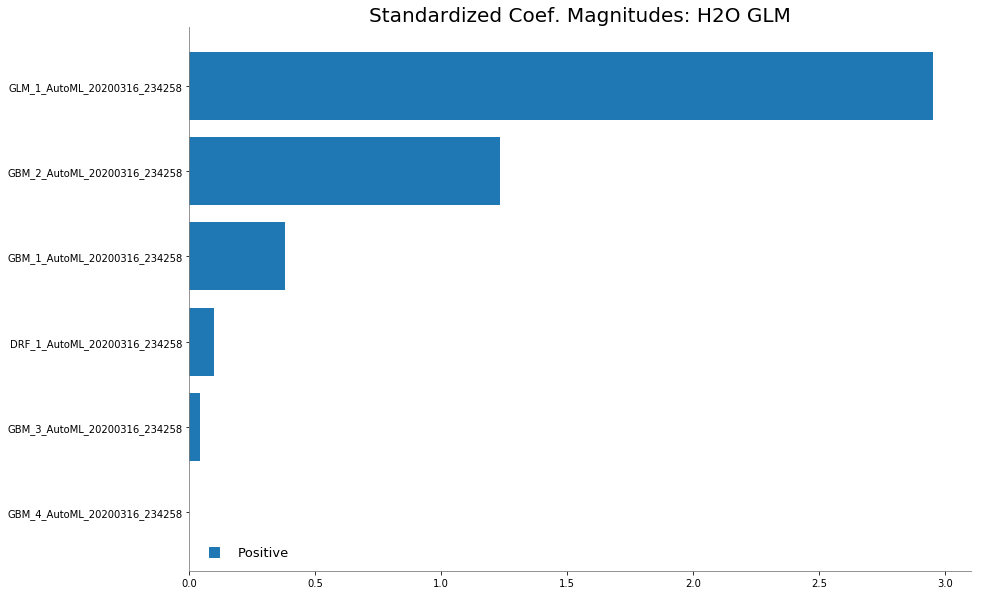

In [17]:
%matplotlib inline
metalearner.std_coef_plot()

#### View Shap values

In [480]:
# 3.if need to explain complicated models
# convert the data format
class H2OProbWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names

    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(h2o.H2OFrame(self.dataframe))
        self.predictions_pd =self.predictions[self.predictions.columns[1:]].as_data_frame()
#         le = LabelEncoder()
#         self.predictions = le.fit_transform(self.predictions[0])
        return self.predictions_pd.values.astype('float64')[:,-1] #probability of True class

In [481]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test = y_test.astype('bool')
y_train = y_train.astype('bool')


In [482]:
# select the GBM data
drf = h2o.get_model("DRF_1_AutoML_20200303_174955")

In [483]:
h2o_wrapper = H2OProbWrapper(drf,feature_names) 

In [487]:
explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, X_test.iloc[:100,:])

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [490]:
shap_values = explainer.shap_values(X_test.iloc[:4,:])

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


In [495]:
shap.force_plot(explainer.expected_value, shap_values)

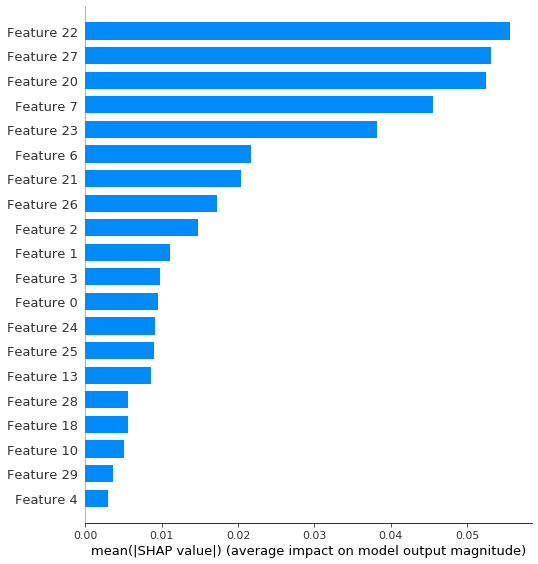

In [496]:
shap.summary_plot(shap_values,plot_type='bar')

### With TPOT

#### 1) Feature Importance 
- This section is only for models that can generate feature importance *

- For the following example, we will use the XGBClassifier generated the first time around to demonstrate Feature importance:

In [ ]:
# Model to demonstrate Feature importance
best_model_xgb = XGBClassifier(learning_rate=0.01, max_depth=10, min_child_weight=18, n_estimators=100,
                               nthread=1, subsample=0.45).fit(X_train,y_train)


##### Print out a list of feature importances:

In [73]:

# Print Out As A List 
important_features = pd.Series(data=best_model_xgb.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
important_features

concavity_mean             0.190095
perimeter_worst            0.174475
concave points_worst       0.157622
area_worst                 0.152959
concave points_mean        0.148902
concavity_worst            0.093756
radius_worst               0.082190
fractal_dimension_worst    0.000000
compactness_mean           0.000000
fractal_dimension_mean     0.000000
symmetry_mean              0.000000
area_mean                  0.000000
smoothness_mean            0.000000
texture_se                 0.000000
perimeter_mean             0.000000
texture_mean               0.000000
radius_se                  0.000000
smoothness_se              0.000000
perimeter_se               0.000000
area_se                    0.000000
symmetry_worst             0.000000
compactness_se             0.000000
concavity_se               0.000000
concave points_se          0.000000
symmetry_se                0.000000
fractal_dimension_se       0.000000
texture_worst              0.000000
smoothness_worst           0

##### Print out as a Bar Chart:

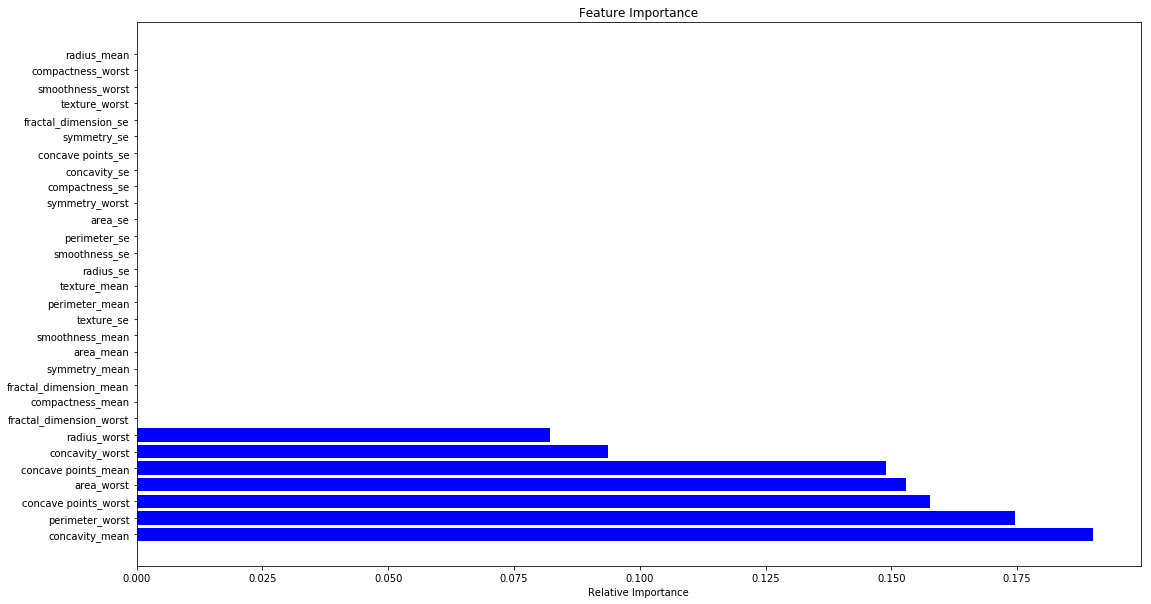

In [75]:
# Create figure and set its size
plt.figure(figsize=(18,10))
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.barh(range(X.shape[1]), important_features, color='b', align='center')
# Add feature names as y-axis labels
plt.yticks(range(len(indices)), names)
plt.xlabel('Relative Importance')
# Show plot
plt.show()

#### 2) Model Parameters 

In [54]:
#Best model_logistic_regression 
best_model_lr = LogisticRegression(C=5.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False).fit(X_train,y_train)
best_model_lr.get_params()

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


{'C': 5.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [51]:
#Best Model - XGBoost 
best_model_xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 18,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': 1,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.45,
 'verbosity': 1}

#### 3) SHAP Values

- Reference: https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

In [64]:
explainer = shap.KernelExplainer(best_model_lr.predict,X_test.iloc[:100,:])
lr_shap_values = explainer.shap_values(X_test.iloc[:4,:])

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [66]:
shap.force_plot(explainer.expected_value, lr_shap_values)

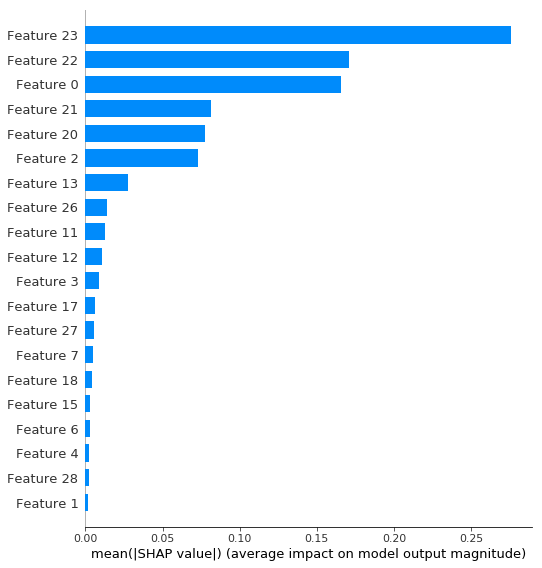

In [67]:
shap.summary_plot(lr_shap_values,plot_type='bar')

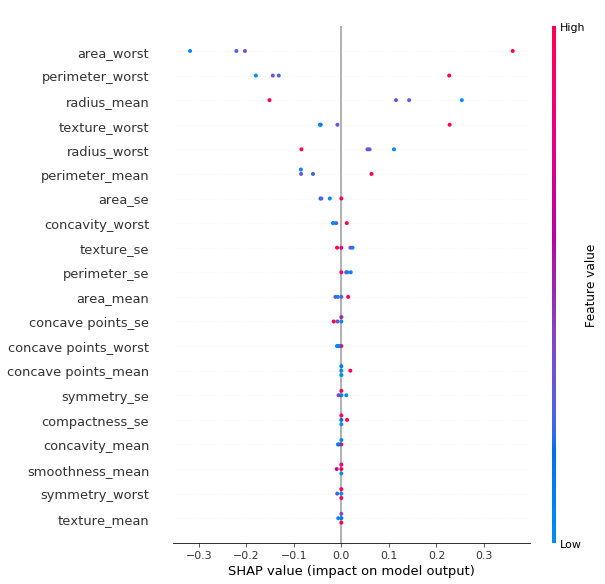

In [79]:
# positive and negative relationships of the predictors with the target variable
shap.summary_plot(lr_shap_values, X_test.iloc[:4,:])

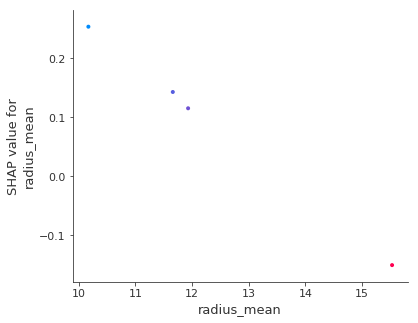

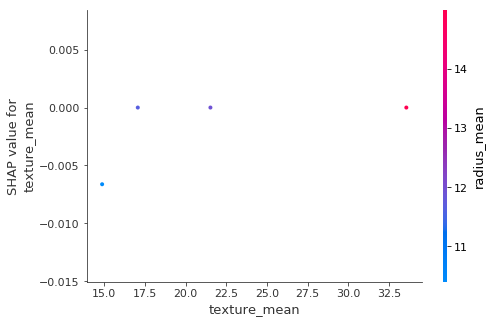

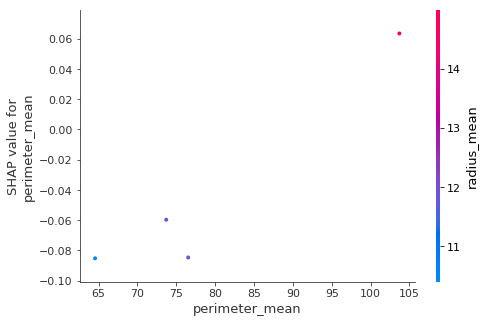

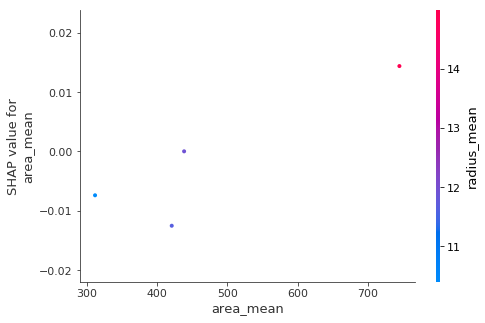

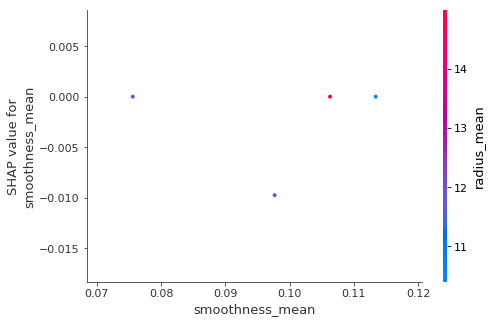

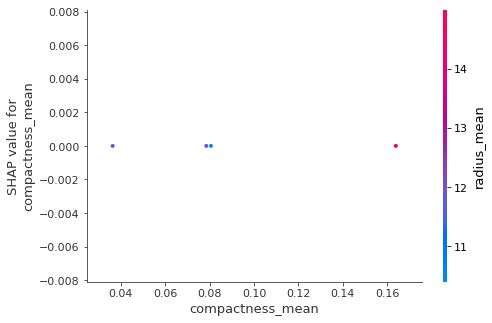

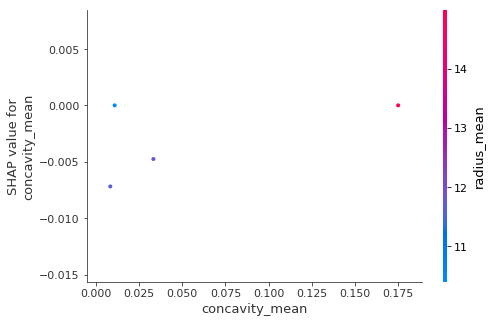

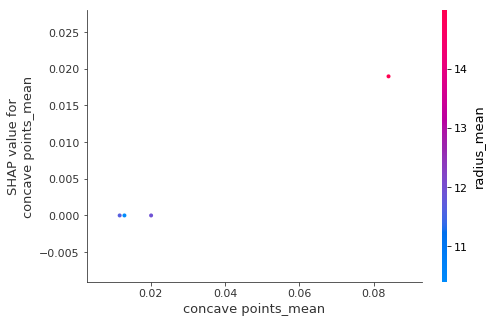

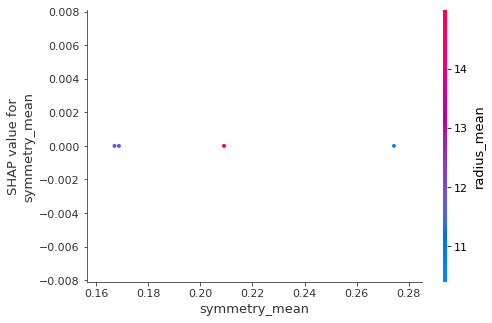

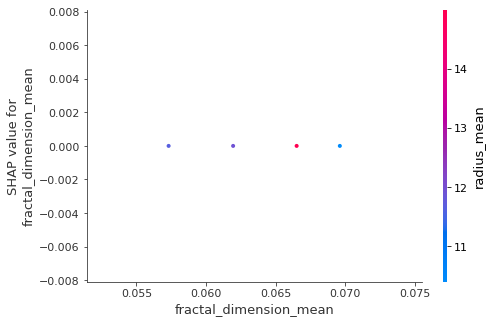

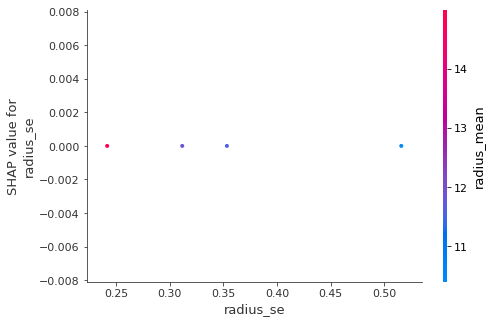

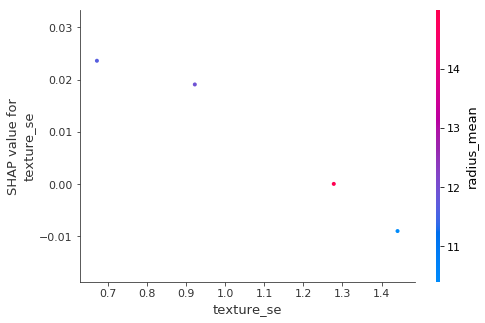

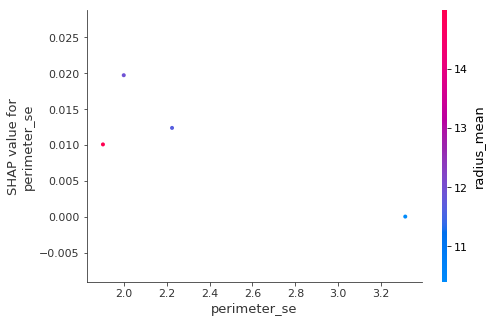

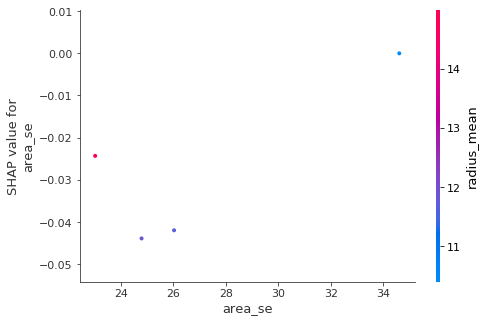

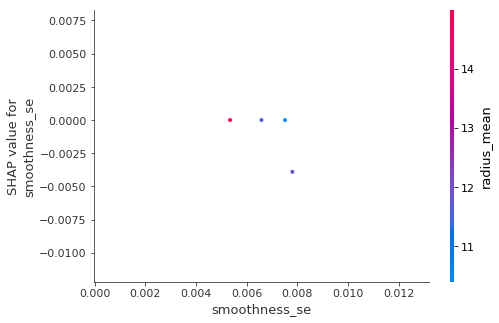

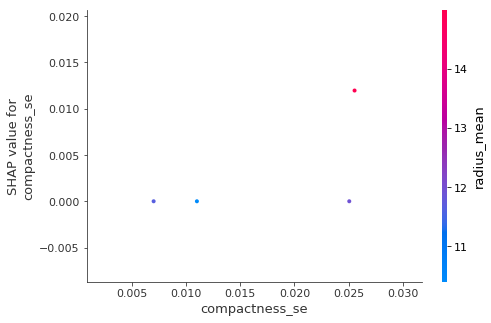

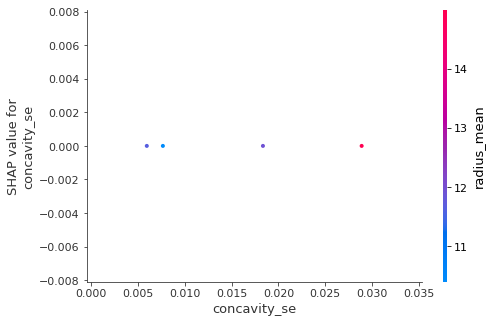

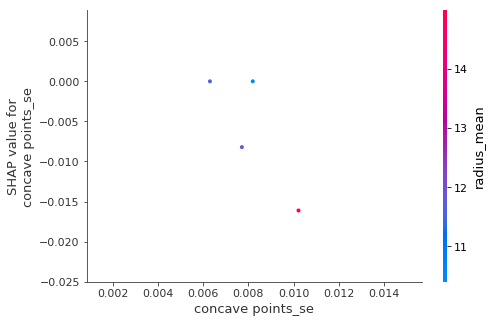

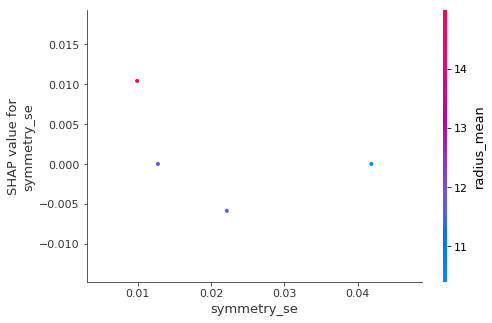

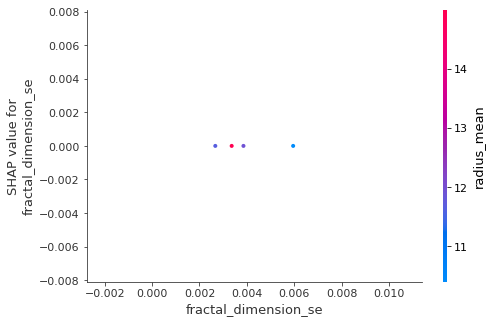

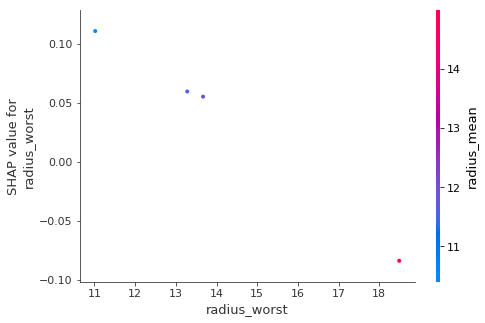

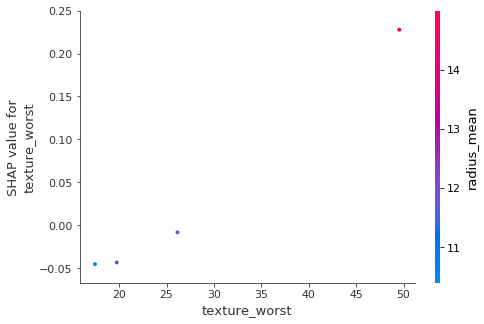

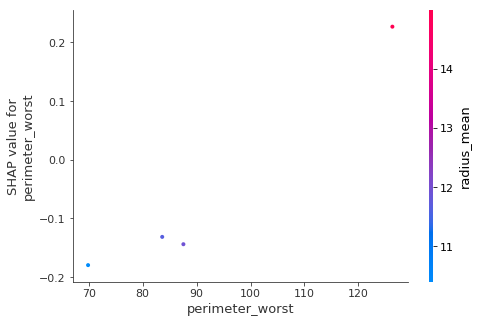

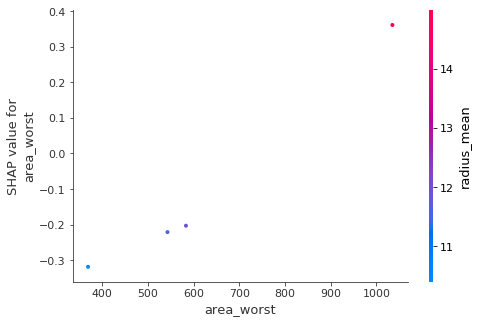

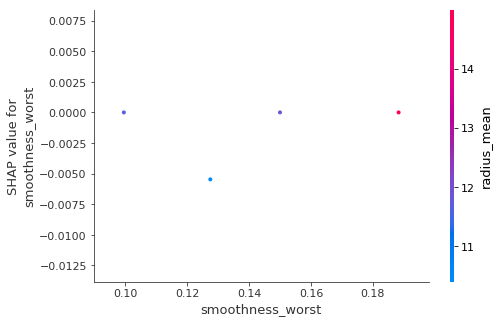

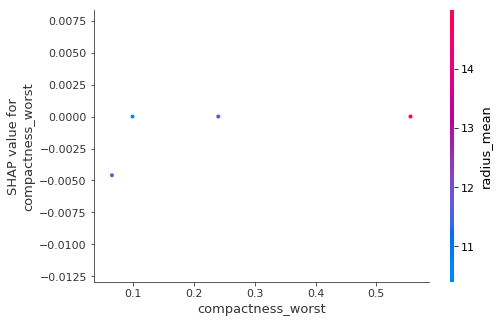

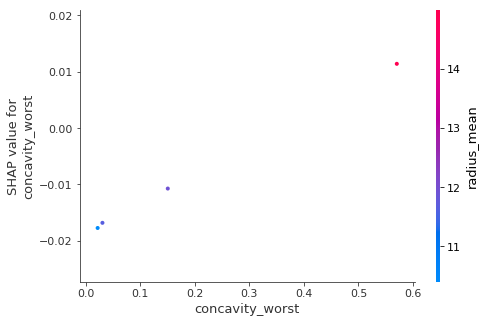

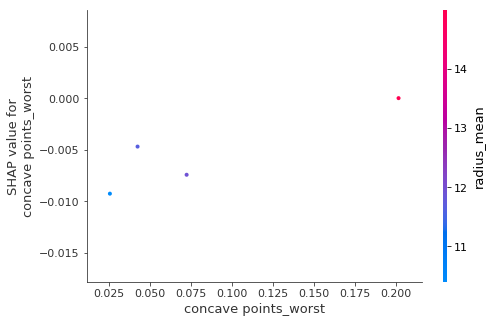

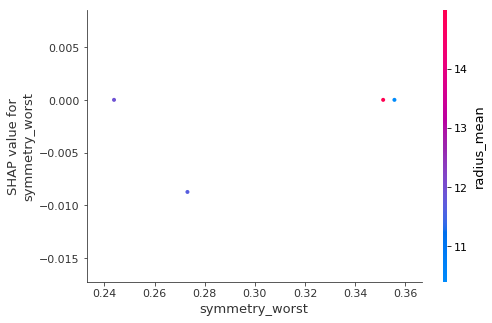

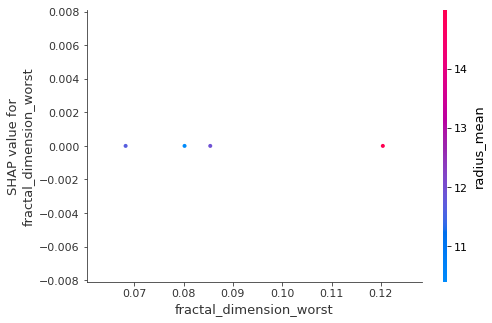

In [80]:
# depedent plot
# relationship between the target and a feature
for name in X.columns:
    shap.dependence_plot(name, lr_shap_values, X_test.iloc[:4,:])

In [83]:
# local interpretability
# individual force plot
shap.force_plot(explainer.expected_value,lr_shap_values[0,:],X_test.iloc[0,:])

In [84]:
# collective plot
shap.force_plot(explainer.expected_value, lr_shap_values, X)

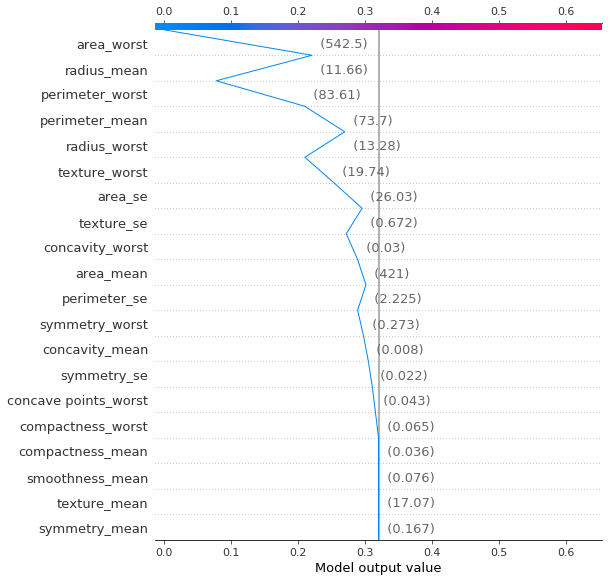

In [86]:
shap.decision_plot(explainer.expected_value,lr_shap_values[0,:],X_test.iloc[0,:])

# AutoML For Regression
- Dataset: Avocado

- Here we will focus on two things: 
    - Use an example for regression 
    - Generate Prediction Intervals
    
- References:
    - https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
    - https://www.kaggle.com/anitha136/avocado-price-prediction


## Data Preparation


In [24]:
df_reg = pd.read_csv('avocado.csv')
df_reg.head()

Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0           0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1           1  2015-12-20          1.35      54876.98   674.28   44638.81   
2           2  2015-12-13          0.93     118220.22   794.70  109149.67   
3           3  2015-12-06          1.08      78992.15  1132.00   71976.41   
4           4  2015-11-29          1.28      51039.60   941.48   43838.39   

     4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0   48.16     8696.87     8603.62       93.25          0.0  conventional   
1   58.33     9505.56     9408.07       97.49          0.0  conventional   
2  130.50     8145.35     8042.21      103.14          0.0  conventional   
3   72.58     5811.16     5677.40      133.76          0.0  conventional   
4   75.78     6183.95     5986.26      197.69          0.0  conventional   

   year  region  
0  2015  Albany  
1  2015  Albany  
2  2015  Albany  
3  2015  Albany  
4  2015  Albany

In [25]:
df_reg.drop("Unnamed: 0", axis=1,inplace=True)
names = ['Date', 'AveragePrice', 'TotalVolume', 'Small', 'Large', 'XLarge', 'TotalBags', 'SmallBags', 'LargeBags', 'XLargeBags', 'Type', 'Year' ,'Region']
df_reg = df_reg.rename(columns=dict(zip(df_reg.columns, names)))
# df_reg.head()


In [4]:
df_reg.describe(include='all').T

count unique           top  freq     mean          std    min  \
Date          18249    169    2016-07-03   108      NaN          NaN    NaN   
AveragePrice  18249    NaN           NaN   NaN  1.40598     0.402677   0.44   
TotalVolume   18249    NaN           NaN   NaN   850644  3.45355e+06  84.56   
Small         18249    NaN           NaN   NaN   293008  1.26499e+06      0   
Large         18249    NaN           NaN   NaN   295155  1.20412e+06      0   
XLarge        18249    NaN           NaN   NaN  22839.7       107464      0   
TotalBags     18249    NaN           NaN   NaN   239639       986242      0   
SmallBags     18249    NaN           NaN   NaN   182195       746179      0   
LargeBags     18249    NaN           NaN   NaN  54338.1       243966      0   
XLargeBags    18249    NaN           NaN   NaN  3106.43      17692.9      0   
Type          18249      2  conventional  9126      NaN          NaN    NaN   
Year          18249    NaN           NaN   NaN  2016.15     0.939938   2015   
Region        18249     54          West   338      NaN          NaN    NaN   

                  25%      50%      75%          max  
Date              NaN      NaN      NaN          NaN  
AveragePrice      1.1     1.37     1.66         3.25  
TotalVolume   10838.6   107377   432962  6.25056e+07  
Small          854.07   8645.3   111020  2.27436e+07  
Large         3008.78    29061   150207  2.04706e+07  
XLarge              0   184.99  6243.42  2.54644e+06  
TotalBags     5088.64  39743.8   110783  1.93731e+07  
SmallBags     2849.42  26362.8  83337.7  1.33846e+07  
LargeBags      127.47  2647.71  22029.2   5.7191e+06  
XLargeBags          0        0    132.5       551694  
Type              NaN      NaN      NaN          NaN  
Year             2015     2016     2017         2018  
Region            NaN      NaN      NaN          NaN

In [5]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   TotalVolume   18249 non-null  float64
 3   Small         18249 non-null  float64
 4   Large         18249 non-null  float64
 5   XLarge        18249 non-null  float64
 6   TotalBags     18249 non-null  float64
 7   SmallBags     18249 non-null  float64
 8   LargeBags     18249 non-null  float64
 9   XLargeBags    18249 non-null  float64
 10  Type          18249 non-null  object 
 11  Year          18249 non-null  int64  
 12  Region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


In [26]:
df_reg = pd.get_dummies(df_reg, columns=['Type'],drop_first=True)
df_reg.head()

Date  AveragePrice  TotalVolume    Small      Large  XLarge  \
0  2015-12-27          1.33     64236.62  1036.74   54454.85   48.16   
1  2015-12-20          1.35     54876.98   674.28   44638.81   58.33   
2  2015-12-13          0.93    118220.22   794.70  109149.67  130.50   
3  2015-12-06          1.08     78992.15  1132.00   71976.41   72.58   
4  2015-11-29          1.28     51039.60   941.48   43838.39   75.78   

   TotalBags  SmallBags  LargeBags  XLargeBags  Year  Region  Type_organic  
0    8696.87    8603.62      93.25         0.0  2015  Albany             0  
1    9505.56    9408.07      97.49         0.0  2015  Albany             0  
2    8145.35    8042.21     103.14         0.0  2015  Albany             0  
3    5811.16    5677.40     133.76         0.0  2015  Albany             0  
4    6183.95    5986.26     197.69         0.0  2015  Albany             0

In [7]:
print("Organic ",df_reg[df_reg["Type_organic"]==1]["Date"].count())
print("conventional ",df_reg[df_reg["Type_organic"]==0]["Date"].count())

Organic  9123
conventional  9126


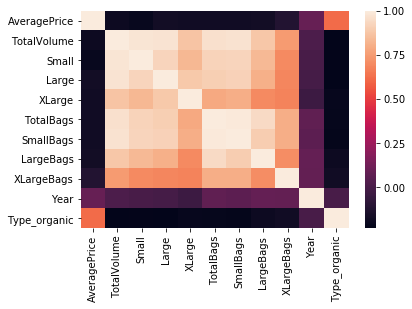

In [8]:
sns.heatmap(df_reg.corr())

In [9]:
df_reg.columns

Index(['Date', 'AveragePrice', 'TotalVolume', 'Small', 'Large', 'XLarge',
       'TotalBags', 'SmallBags', 'LargeBags', 'XLargeBags', 'Year', 'Region',
       'Type_organic'],
      dtype='object')

In [27]:
le = LabelEncoder()
df_reg['Region'] = le.fit_transform(df_reg['Region'])
df_reg.head()

Date  AveragePrice  TotalVolume    Small      Large  XLarge  \
0  2015-12-27          1.33     64236.62  1036.74   54454.85   48.16   
1  2015-12-20          1.35     54876.98   674.28   44638.81   58.33   
2  2015-12-13          0.93    118220.22   794.70  109149.67  130.50   
3  2015-12-06          1.08     78992.15  1132.00   71976.41   72.58   
4  2015-11-29          1.28     51039.60   941.48   43838.39   75.78   

   TotalBags  SmallBags  LargeBags  XLargeBags  Year  Region  Type_organic  
0    8696.87    8603.62      93.25         0.0  2015       0             0  
1    9505.56    9408.07      97.49         0.0  2015       0             0  
2    8145.35    8042.21     103.14         0.0  2015       0             0  
3    5811.16    5677.40     133.76         0.0  2015       0             0  
4    6183.95    5986.26     197.69         0.0  2015       0             0

#### Selecting  Columns

In [11]:
df_reg.columns

Index(['Date', 'AveragePrice', 'TotalVolume', 'Small', 'Large', 'XLarge',
       'TotalBags', 'SmallBags', 'LargeBags', 'XLargeBags', 'Year', 'Region',
       'Type_organic'],
      dtype='object')

In [28]:
df_avocado=df_reg[['AveragePrice', 'TotalVolume', 'Small', 'Large', 'XLarge',
       'TotalBags', 'SmallBags', 'LargeBags', 'XLargeBags', 'Year', 'Region',
       'Type_organic']]
df_avocado.head()

AveragePrice  TotalVolume    Small      Large  XLarge  TotalBags  \
0          1.33     64236.62  1036.74   54454.85   48.16    8696.87   
1          1.35     54876.98   674.28   44638.81   58.33    9505.56   
2          0.93    118220.22   794.70  109149.67  130.50    8145.35   
3          1.08     78992.15  1132.00   71976.41   72.58    5811.16   
4          1.28     51039.60   941.48   43838.39   75.78    6183.95   

   SmallBags  LargeBags  XLargeBags  Year  Region  Type_organic  
0    8603.62      93.25         0.0  2015       0             0  
1    9408.07      97.49         0.0  2015       0             0  
2    8042.21     103.14         0.0  2015       0             0  
3    5677.40     133.76         0.0  2015       0             0  
4    5986.26     197.69         0.0  2015       0             0

#### Scale & Split Data 

In [29]:
scaler = StandardScaler().fit(df_avocado)
df_avocado_std = scaler.transform(df_avocado)
df_avocado = pd.DataFrame(df_avocado_std)
df_avocado.columns = ['AveragePrice', 'TotalVolume', 'Small', 'Large', 'XLarge',
       'TotalBags', 'SmallBags', 'LargeBags', 'XLargeBags', 'Year', 'Region',
       'Type_organic']

feature_cols = ['TotalVolume', 'Small', 'Large', 'XLarge',
       'TotalBags', 'SmallBags', 'LargeBags', 'XLargeBags', 'Year', 'Region',
       'Type_organic']              # create a Python list of feature names
X = df_avocado[feature_cols]                                     # use the list to select a subset of the original DataFrame-+

y = df_avocado.AveragePrice


def split(X,y):
    return train_test_split(X, y, test_size=0.20, random_state=1)

X_train, X_test, y_train, y_test=split(X,y)

print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)

print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.


X_train shape:  (14599, 11)
y_train shape:  (14599,)
X_test shape:  (3650, 11)
y_test shape:  (3650,)


## Predicting Avocado Price With TPOT Regressor

#### Using TPOT Regressor to determine best pipeline

In [16]:
from tpot import TPOTRegressor

In [17]:
# Current Parameters set to default values 
def tpotRegression(exported_pipeline_name,X_train,y_train,X_test,y_test,gen=100,mr=0.9,cr=0.1,
                       scoring_metric='neg_mean_squared_error',cv=5,verbosity=2,max_time_mins=None, max_eval_time_mins=5,
                       population_size=100):
    
    # Defining the Regressor    
    tpot = TPOTRegressor(generations=gen,mutation_rate=mr,crossover_rate=cr,
                          scoring=scoring_metric,cv=cv,verbosity=verbosity,max_time_mins=max_time_mins,
                          max_eval_time_mins=max_eval_time_mins,
                       population_size=population_size)
    print(tpot)
    
    # Training the Regressor
    start = timer()
    tpot.fit(X_train,y_train)
    runtime = timer()-start
    print(f'Runtime in seconds: {runtime}\n ')
    
    # generating Predictions
    predictions = tpot.predict(X_test)
    
    # printing Training Score
    training_score = tpot.score(X_train,y_train)
    print(f"Train {scoring_metric} score:{training_score}\n")
    
    # printing Validation(Test) Score
    validation_score = tpot.score(X_test,y_test)
    print(f"Test {scoring_metric} score:{validation_score}\n")
        
    # Get the best model
    extracted_best_model = tpot.fitted_pipeline_.steps[-1][1]

    print(extracted_best_model)
    
    # Export optimized pipeline as Python code.
    tpot.export(f'{exported_pipeline_name}.py')
    
    # Return predictions,training_score,validation_score 
    return extracted_best_model, predictions,training_score,validation_score


best_model,predictions,train_score,valid_score =  tpotRegression('tpot_avocado_price',X_train,y_train,X_test,y_test,gen=5)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=5,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=100,
       random_state=None, scoring='neg_mean_squared_error', subsample=1.0,
       template=None, use_dask=False, verbosity=2, warm_start=False)


Generation 1 - Current best internal CV score: -0.14713012692949295
Generation 2 - Current best internal CV score: -0.13900955244777977
Generation 3 - Current best internal CV score: -0.13900955244777977
Generation 4 - Current best internal CV score: -0.13900955244777977
Generation 5 - Current best internal CV score: -0.13900955244777977

Best pipeline: ExtraTreesRegressor(Normalizer(input_matrix, norm=l2), bootstrap=False, max_features=0.6500000000000001, min_samples_leaf=3, min_samples_split=5, n_estimators=100)
Runtime in seconds: 9538.3181533
 
Train neg_mean_squared_error score:-0.052468233780661865

Test neg_mean_squared_error score:-0.12517237760249827

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=0.6500000000000001, max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=3, min_samples_split=5,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
          oob

#### Save Best Model

In [2]:
import joblib

In [38]:
joblib.dump(best_model,'ExtraTreesRegressor')

['ExtraTreesRegressor']

#### Save Predictions

In [5]:
from numpy import savetxt
from numpy import loadtxt

savetxt('avocado_predictions.csv', predictions, delimiter=',')
# loadtxt('avocado_predictions.csv', delimiter=',')

array([ 1.30797333, -1.01510165, -0.29497146, ..., -0.77562494,
       -0.41354973,  1.2298671 ])

#### Exported Pipeline Code (from tpot_avocado_price.py) : 

In [32]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('avocado.csv', sep=',', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:-0.13900955244777977
exported_pipeline = make_pipeline(
    Normalizer(norm="l2"),
    ExtraTreesRegressor(bootstrap=False, max_features=0.6500000000000001, min_samples_leaf=3, min_samples_split=5, n_estimators=100)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


FileNotFoundError: [Errno 2] No such file or directory: 'PATH/TO/DATA/FILE'

## Predicting Avocado Price Without TPOT

#### Linear Regression Avocado Price Prediction

##### Linear Model

In [40]:
linreg2 = LinearRegression()
linreg2.fit(X_train, y_train) 

feature_cols.insert(0,'Intercept')
coef = linreg2.coef_.tolist()
coef.insert(0, linreg2.intercept_)
eq1 = zip(feature_cols, coef)

for c1,c2 in eq1:
    print(c1,c2)

y_pred_train = linreg2.predict(X_train)
y_pred_test = linreg2.predict(X_test)

Intercept -0.002350575426704923
TotalVolume -517.6834804238257
Small 189.31964172692125
Large 180.83743711568573
XLarge 15.996361634303398
TotalBags 4352.096565205801
SmallBags -3180.859541759348
LargeBags -1040.0915294830256
XLargeBags -75.34998304840143
Year 0.09258218687557473
Region 0.012235265604083168
Type_organic 0.6054455041350657


##### Evaluate Linear Model 

In [43]:
print("Model Evaluation for Linear Regression Model 2")

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print('RMSE for training set is {}'.format(RMSE_train),' and RMSE for test set is {}'.format(RMSE_test))

yhat = linreg2.predict(X_train)
SS_Residual = sum((y_train-yhat)**2)
SS_Total = sum((y_train-np.mean(y_train))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print("r_squared for train data ",r_squared, "and adjusted_r_squared for train data",adjusted_r_squared)

yhat = linreg2.predict(X_test)
SS_Residual = sum((y_test-yhat)**2)
SS_Total = sum((y_test-np.mean(y_test))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("r_squared for test data ",r_squared, "and adjusted_r_squared for test data",adjusted_r_squared)

Model Evaluation for Linear Regression Model 2
RMSE for training set is 0.7706964525653109  and RMSE for test set is 0.7686205107189428
r_squared for train data  0.40576488778920883 and adjusted_r_squared for train data 0.405316777400896
r_squared for test data  0.41025749859349203 and adjusted_r_squared for test data 0.4084743299526258


#### Random Forest Avocado Price Prediction

##### RF Model

In [47]:
model2 = RandomForestRegressor(random_state = 0)
model2.fit(X_train, y_train)
y_pred_train = model2.predict(X_train)
y_pred_test = model2.predict(X_test)

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


##### RF Model Evaluation

In [48]:
print("Model Evaluation for Random Forest Regressor ")
RMSE_train = np.sqrt( mean_squared_error(y_train, y_pred_train))
RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print('RMSE for training set is {}'.format(RMSE_train),' and RMSE for test set is {}'.format(RMSE_test))

yhat = model2.predict(X_train)
SS_Residual = sum((y_train-yhat)**2)
SS_Total = sum((y_train-np.mean(y_train))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print("r_squared for train data ",r_squared, " and adjusted_r_squared for train data",adjusted_r_squared)

yhat = model2.predict(X_test)
SS_Residual = sum((y_test-yhat)**2)
SS_Total = sum((y_test-np.mean(y_test))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("r_squared for test data ",r_squared, " and adjusted_r_squared for test data",adjusted_r_squared)

Model Evaluation for Random Forest Regressor 
RMSE for training set is 0.18120918856840879  and RMSE for test set is 0.4122760029287483
r_squared for train data  0.9671487407747197  and adjusted_r_squared for train data 0.9671239677678315
r_squared for test data  0.8303262719251798  and adjusted_r_squared for test data 0.8298132397622269


# Generating Prediction Intervals

#### For GradientBoostingRegressor
- Reference: - https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed
    - https://nbviewer.jupyter.org/github/WillKoehrsen/Data-Analysis/blob/master/prediction-intervals/prediction_intervals.ipynb

In [66]:
# Model 
from sklearn.ensemble import GradientBoostingRegressor

# Interactivity
from ipywidgets import interact, widgets

# Visualization

# Plotly
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly_express as px

# cufflinks is a wrapper on plotly
import cufflinks as cf
cf.go_offline(connected=True)

##### Build Models for Lower, Upper Quantile and Median

In [67]:
# Set lower and upper quantile
LOWER_ALPHA = 0.15
UPPER_ALPHA = 0.85

N_ESTIMATORS = 100
MAX_DEPTH = 5

# Each model has to be separate

lower_model = GradientBoostingRegressor(
    loss="quantile", alpha=LOWER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH
)
# The mid model will use the default
mid_model = GradientBoostingRegressor(loss="ls", n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

upper_model = GradientBoostingRegressor(
    loss="quantile", alpha=UPPER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH
)


##### Train Models
- The models are trained based on optimizing for the specific loss function. This means we have to build 3 separate models to predict the different objectives. A downside of this method is that it's a little slow, particularly because we can't parallelize training on the Scikit-Learn Gradient Boosting Regresssor. If you wanted, you could re-write this code to train each model on a separate processor (using multiprocessing.)

In [68]:
_ = lower_model.fit(X_train, y_train)
_ = mid_model.fit(X_train, y_train)
_ = upper_model.fit(X_train, y_train)

##### Make Predictions
- With the models all trained, we now make predictions and record them with the true values.

In [69]:
predictions = pd.DataFrame(y_test)
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

assert (predictions['upper'] > predictions['lower']).all()

predictions.tail()

AveragePrice     lower       mid     upper
4471      -0.735048 -1.143408 -0.721173 -0.295720
12556     -0.362530 -0.246606  0.169250  0.593336
9063      -0.884055 -1.109149 -1.052001 -0.244462
7497      -0.238358 -0.954991 -0.306408  0.075111
9151       1.574561  0.534734  1.081150  1.396758

##### Prediction Intervals Plot
- The best way to inspect these results is visually. Here we use plotly to make a filled area chart showing the prediction intervals.

In [128]:
base_model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
base_model.fit(X_train,y_train)
base_prediction = base_model.predict(X_test)
#compute the prediction error vector on the validation set
validation_error = (base_prediction - y_test) ** 2

error_model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
error_model.fit(X_test, validation_error) 

# compute the mean and standard deviation of the distribution 
mean = base_model.predict(X_test) 
st_dev = error_model.predict(X_test)**0.5

C:\Users\ranon\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

invalid value encountered in sqrt



#### For TPOT Extra Trees Regressor Model

In [3]:
best_model = joblib.load('ExtraTreesRegressor')

In [6]:
predictions = loadtxt('avocado_predictions.csv', delimiter=',')

#### For SKGarden Extra Trees Quantile Regressor Model
- Reference: https://scikit-garden.github.io/examples/QuantileRegressionForests/

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from skgarden import RandomForestQuantileRegressor

In [60]:
rfqr = RandomForestQuantileRegressor(
    random_state=0, min_samples_split=10, n_estimators=1000)
rfqr.set_params(max_features=X_train.shape[1] // 3)
rfqr.fit(X_train, y_train)

In [64]:
y_true_all = []
lower = []
upper = []

y_true_all = np.concatenate((y_true_all, y_test))
upper = np.concatenate((upper, rfqr.predict(X_test, quantile=95)))
lower = np.concatenate((lower, rfqr.predict(X_test, quantile=5)))


interval = upper - lower
sort_ind = np.argsort(interval)
y_true_all = y_true_all[sort_ind]
upper = upper[sort_ind]
lower = lower[sort_ind]
mean = (upper + lower) / 2

# Center such that the mean of the prediction interval is at 0.0
y_true_all -= mean
upper -= mean
lower -= mean

KeyboardInterrupt: 

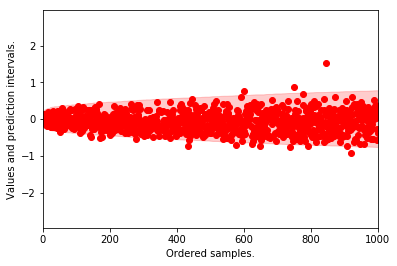

In [63]:
plt.plot(y_true_all, "ro")
plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 1000])
plt.show()

#### For Random Forest Regressor Model

- Reference : https://blog.datadive.net/prediction-intervals-for-random-forests/

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
trainsize = 400
idx = range(size)
#shuffle the data
np.random.shuffle(list(idx))
rf = RandomForestRegressor(n_estimators=1000, min_samples_leaf=1)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [50]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X[x].reshape(1, -1))[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

##### Percentage of actual points that lie within the 90% prediction interval 

In [51]:
err_down, err_up = pred_ints(rf, X_test.values, percentile=90)
 
truth = y_test.values
correct = 0.
for i, val in enumerate(truth):
    if err_down[i] <= val <= err_up[i]:
        correct += 1
print(correct/len(truth))

0.9167123287671233


#### Comparing Prediction Interval of Models
- Reference: https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3
    - https://colab.research.google.com/drive/1nXOlrmVHqCHiixqiMF6H8LSciz583_W2#scrollTo=hn3sxw4yDXdz

In [104]:
X_test_one_feature = X_test.Type_organic
METHODS = ['Random forests', 'Gradient boosting']
QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]
quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

# sns.set_palette(sns.color_palette('Blues', len(QUANTILES)))
sns.set_palette(sns.color_palette('Blues'))
# Set dots to a light gray
dot_color = sns.color_palette('coolwarm', 3)[1]


preds = np.array([(method, q, x) 
                  for method in METHODS 
                  for q in QUANTILES
                  for x in X_test_one_feature])
preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'x']
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))

preds['label'] = np.resize(y_test, preds.shape[0])

##### Random Forests

In [105]:
def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    rf_preds = np.array(rf_preds).transpose()  # One row per record.
    return np.percentile(rf_preds, q * 100, axis=1)

In [106]:
preds_full = preds[['method', 'q', 'label']].copy(deep=True)

In [107]:
preds_full.loc[preds_full.method == 'Random forests', 'pred'] = np.concatenate(
    [rf_quantile(rf, X_test, q) for q in QUANTILES]) 

##### Gradient Boosted Trees

In [111]:
def gb_quantile(X_train, train_labels, X, q):
    gbf = GradientBoostingRegressor(loss='quantile', alpha=q,
                                             n_estimators=N_ESTIMATORS,
                                             max_depth=3,
                                             learning_rate=0.1, min_samples_leaf=9,
                                             min_samples_split=9)
    gbf.fit(X_train, train_labels)
    return gbf.predict(X)

In [112]:
preds_full.loc[preds_full.method == 'Gradient boosting', 'pred'] = \
    np.concatenate([gb_quantile(X_train, y_train, X_test, q) 
                    for q in QUANTILES])

##### Comparing Quantile Losses

In [116]:
# pandas version rather than Keras.
def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

In [117]:
preds_full['quantile_loss'] = quantile_loss(preds_full.q, preds_full.label, 
                                            preds_full.pred)

In [118]:
def plot_loss_comparison(preds):
    overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
      pivot_table(index='method', values='quantile_loss').\
      sort_values('quantile_loss')
    # Show overall table.
    print(overall_loss_comparison)
  
    # Plot overall.
    with sns.color_palette('Blues', 1):
        ax = overall_loss_comparison.plot.barh()
        plt.title('Total quantile loss', loc='left')
        sns.despine(left=True, bottom=True)
        plt.xlabel('Quantile loss')
        plt.ylabel('')
        ax.legend_.remove()
  
    # Per quantile.
    per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
        pivot_table(index='q', columns='method', values='quantile_loss')
    # Sort by overall quantile loss.
    per_quantile_loss_comparison = \
        per_quantile_loss_comparison[overall_loss_comparison.index]
    print(per_quantile_loss_comparison)
  
    # Plot per quantile.
    with sns.color_palette('Blues'):
        ax = per_quantile_loss_comparison.plot.barh()
        plt.title('Quantile loss per quantile', loc='left')
        sns.despine(left=True, bottom=True)
        handles, labels = ax.get_legend_handles_labels()
        plt.xlabel('Quantile loss')
        plt.ylabel('Quantile')
        # Reverse legend.
        ax.legend(reversed(handles), reversed(labels))

                   quantile_loss
method                          
Random forests          0.092337
Gradient boosting       0.153673
method  Random forests  Gradient boosting
q                                        
0.1           0.058231           0.090128
0.3           0.108292           0.179615
0.5           0.123620           0.210006
0.7           0.109344           0.186964
0.9           0.062199           0.101653


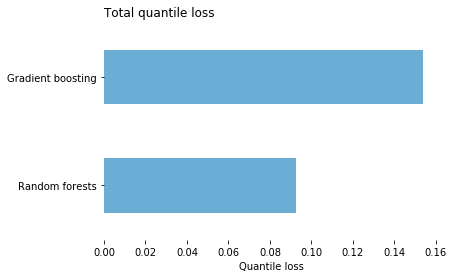

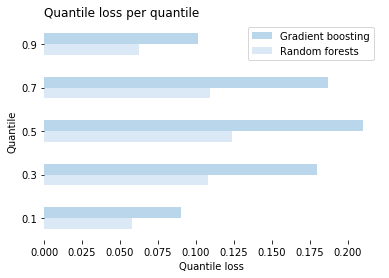

In [119]:
plot_loss_comparison(preds_full)

In [120]:
import pickle

!mkdir quantile_regression_comparison

for i in ['preds']:
    pickle.dump(eval(i),
                open('quantile_regression_comparison/' + i + '.p', 'wb'))

# AutoML for large dataset

In [483]:
credit = pd.read_csv('creditcard.csv')

In [479]:
credit

Time         V1         V2         V3        V4         V5  \
0            0  -5.439229  -0.291125  10.145387  5.512621  -1.353283   
1            0   4.767428   1.064603   0.665920  1.792616   0.240071   
2            4  -5.433416  -5.360652   7.092837  1.519118  -2.012793   
3            4  -3.865087  -0.740904   7.171973 -3.453165  -0.041236   
4            8  -4.632932   3.510947   6.194871  1.612136  -1.628774   
...        ...        ...        ...        ...       ...        ...   
284802  691144 -47.524472  40.287140 -39.339134 -8.266623 -21.457891   
284803  691148  -2.931155  -0.220322   8.140119 -2.954354   3.472918   
284804  691152   7.678260  -1.205015 -12.998559 -2.231312  10.522060   
284805  691152  -0.961760   2.121930   2.810041  2.759197  -1.511845   
284806  691168  -2.133650  -0.758933   2.813349 -2.025085  -0.050183   

               V6         V7         V8        V9  ...       V21       V22  \
0        1.849551   0.958394   0.394792  1.455148  ... -0.073227  1.111350   
1       -0.329443  -0.315212   0.340407 -1.021701  ... -0.903101 -2.554688   
2        7.201998   3.165844   0.990703 -6.058617  ...  0.991993  3.086718   
3        4.988813   0.950436   1.509743 -5.548096  ... -0.433202  0.021094   
4        0.383686   2.371763  -1.082131  3.270957  ... -0.037723  3.193114   
...           ...        ...        ...       ...  ...       ...       ...   
284802 -10.427349 -19.672862  29.221336  7.657713  ...  0.853816  0.447455   
284803   4.233661   0.097319   1.179475  2.339200  ...  0.856821  3.697534   
284804  12.125040  -1.187306   2.833669  1.729816  ...  0.928180  2.312916   
284805   2.494831  -2.744720   2.716582  1.568347  ...  1.060980  3.200195   
284806  -2.598467   6.308025  -1.658602  1.944718  ...  1.044229  2.572314   

             V23       V24       V25       V26       V27       V28   Amount  \
0      -0.441896  0.267712  0.514157 -0.756459  0.534234 -0.084212   598.48   
1       0.405152 -1.359386  0.668682  0.503578 -0.035932  0.058897    10.76   
2       3.637649 -2.757124 -1.310567 -0.556386 -0.221411 -0.239007  1514.64   
3      -0.761282 -4.702301  2.589504 -0.887715  0.250891  0.245831   494.00   
4      -0.549832  0.565068 -0.824038  2.009169  0.877689  0.860613   279.96   
...          ...       ...       ...       ...       ...       ...      ...   
284802  4.057920 -2.037394  5.747228  1.000137  3.774605  3.294924     3.08   
284803  0.049852 -4.064903 -2.426496 -1.581020  0.273890 -0.214110    99.16   
284804 -0.150003  2.560536  1.062982 -0.349482  0.017819 -0.106243   271.52   
284805 -0.653192  0.492821 -2.276635  2.186674  0.435283  0.418131    40.00   
284806  1.507108  0.035190 -1.894595 -3.273068 -0.009661  0.054596   868.00   

                           Class  
0       NormalNormalNormalNormal  
1       NormalNormalNormalNormal  
2       NormalNormalNormalNormal  
3       NormalNormalNormalNormal  
4       NormalNormalNormalNormal  
...                          ...  
284802  NormalNormalNormalNormal  
284803  NormalNormalNormalNormal  
284804  NormalNormalNormalNormal  
284805  NormalNormalNormalNormal  
284806  NormalNormalNormalNormal  

[284807 rows x 31 columns]

In [438]:
credit.loc[credit['Class']==0, 'Class'] ="Normal"
credit.loc[credit['Class']==1, 'Class'] ="Abormal"

In [439]:
credit = h2o.H2OFrame(credit)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [466]:
splits = credit.split_frame(ratios=[0.7],seed=1)
train = splits[0]
test = splits[1]

In [475]:
start = timer()
aml = H2OAutoML(max_models=1,seed=1)
aml.train(y="Class", training_frame=train)
run_time = timer()-start
print(run_time)

AutoML progress: |
16:45:22.795: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%
46.11883525288431


In [476]:
lb = aml.leaderboard
lb.head()

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 GLM_1_AutoML_20200213_164522 0.974027 0.0045291 0.980102 0.130495 0.0284607 0.000810013

In [470]:
pred = aml.predict(test.drop('Class'))

glm prediction progress: |████████████████████████████████████████████████| 100%


In [471]:
pred

predict Abormal Normal 
 
 
 Normal 0.000520518 0.999479 
 Normal 0.000266289 0.999734 
 Normal 0.000685814 0.999314 
 Normal 0.000153821 0.999846 
 Normal 9.08981e-05 0.999909 
 Normal 6.71578e-05 0.999933 
 Normal 0.000337147 0.999663 
 Normal 0.000484764 0.999515 
 Normal 0.000728191 0.999272 
 Normal 0.00299072 0.997009

In [472]:
print("H2O: " + str(accuracy_score(test['Class'].as_data_frame(), pred['predict'].as_data_frame())))

H2O: 0.9993778831594146


In [458]:
confusion_matrix(test['Class'].as_data_frame(), pred['predict'].as_data_frame())

array([[  105,    34],
       [   19, 85035]], dtype=int64)

# XGBoost, LightGBM and Catboost

In [345]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from timeit import default_timer as timer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap
shap.initjs()

In [122]:
cancer = pd.read_csv('breast_cancer.csv')

In [123]:
# brief understanding of the data 
print('Rows:', cancer.shape[0])
print('Columns:', cancer.shape[1])
print('Features:\n', cancer.columns.tolist())
print('Missing Values:\n', cancer.isnull().sum().values.sum())

Rows: 569
Columns: 33
Features:
 ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']
Missing Values:
 569


In [126]:
# drop the NA column
cancer = cancer.drop(columns=['Unnamed: 32'])

In [124]:
cancer.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

In [125]:
# 1 = M = malignant, 0 = B = benign
le = LabelEncoder()
cancer['diagnosis'] = le.fit_transform(cancer['diagnosis'])

In [8]:
X = cancer.drop(columns=['id','diagnosis'])
y = cancer['diagnosis']

In [9]:
# split the data and change to array format for the model
X_train,X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state = 7)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [10]:
# parameter setting
params_xgb ={
    'eta' : 0.001,
    'objective':'binary:logistic',
    'early_stopping_rounds':30,
    'booster': 'gbtree',
    'max_depth': 5
}


In [11]:
params_lgb ={
    'learning_rate'==0.001,
    'objective'== 'binary',
    'early_stopping_rounds'== 30,
    'boosting_type'=='goss',
    'max_depth'== 5
}

In [12]:
def GBM():
    start = timer()
    model = GradientBoostingClassifier()
    gbm = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = gbm.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    y_pred_prob = model.predict_proba(X_test)[::,1]
    auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy, 'roc_auc_score':auc_roc}

In [13]:
def XGB():
    start = timer()
    model = XGBClassifier(params = params_xgb)
    xgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    y_pred_prob = xgb.predict_proba(X_test)[::,1]
    auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy, 'roc_auc_score':auc_roc}
    

In [14]:
def LGB():
    start = timer()
    model = LGBMClassifier()
    lgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = lgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    y_pred_prob = lgb.predict_proba(X_test)[::,1]
    auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy, 'roc_auc_score':auc_roc}

In [15]:
def LGB2():
    start = timer()
    model = LGBMClassifier(params = params_lgb)
    lgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = lgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    y_pred_prob = lgb.predict_proba(X_test)[::,1]
    auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy, 'roc_auc_score':auc_roc}

In [16]:
def CGB():
    start = timer()
    model = CatBoostClassifier()
    cgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = cgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    y_pred_prob = cgb.predict_proba(X_test)[::,1]
    auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy, 'roc_auc_score':auc_roc}

GBM: {'train_time': 0.5685202653554823, 'accuracy': 0.9824561403508771, 'roc_auc_score': 0.9973354231974922}


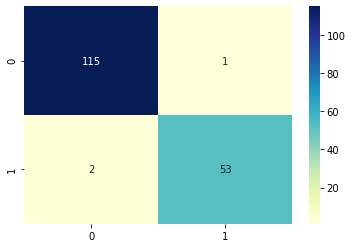

In [17]:
print('GBM:' ,GBM())

XGB: {'train_time': 0.18769762223598763, 'accuracy': 0.9766081871345029, 'roc_auc_score': 0.9962382445141066}


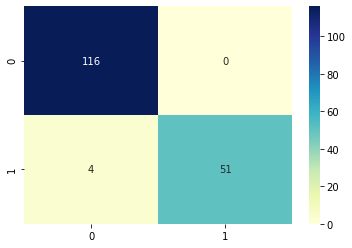

In [18]:
print('XGB:' ,XGB())

LGB: {'train_time': 0.21804900491694146, 'accuracy': 0.9649122807017544, 'roc_auc_score': 0.997962382445141}


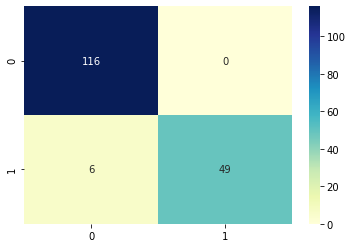

In [19]:
print('LGB:' ,LGB())

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: params keyword has been found in `params` and will be ignored.
Please use params argument of the Dataset constructor to pass this parameter.
  .format(key))


LGB2: {'train_time': 0.2591570002801604, 'accuracy': 0.9649122807017544, 'roc_auc_score': 0.997962382445141}


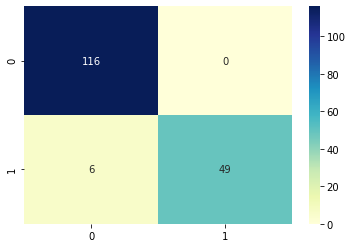

In [20]:
print('LGB2:' ,LGB2())

Learning rate set to 0.006952
0:	learn: 0.6816831	total: 66.1ms	remaining: 1m 6s
1:	learn: 0.6709167	total: 73.7ms	remaining: 36.8s
2:	learn: 0.6600213	total: 81.7ms	remaining: 27.1s
3:	learn: 0.6497917	total: 89.8ms	remaining: 22.4s
4:	learn: 0.6384865	total: 97.6ms	remaining: 19.4s
5:	learn: 0.6297948	total: 105ms	remaining: 17.5s
6:	learn: 0.6187985	total: 113ms	remaining: 16s
7:	learn: 0.6090318	total: 120ms	remaining: 14.9s
8:	learn: 0.5988715	total: 129ms	remaining: 14.2s
9:	learn: 0.5910910	total: 136ms	remaining: 13.5s
10:	learn: 0.5819848	total: 145ms	remaining: 13s
11:	learn: 0.5727573	total: 153ms	remaining: 12.6s
12:	learn: 0.5646200	total: 160ms	remaining: 12.2s
13:	learn: 0.5563230	total: 167ms	remaining: 11.8s
14:	learn: 0.5496699	total: 174ms	remaining: 11.4s
15:	learn: 0.5413030	total: 181ms	remaining: 11.1s
16:	learn: 0.5344583	total: 189ms	remaining: 10.9s
17:	learn: 0.5272128	total: 197ms	remaining: 10.7s
18:	learn: 0.5201599	total: 204ms	remaining: 10.5s
19:	learn:

160:	learn: 0.1218567	total: 1.31s	remaining: 6.82s
161:	learn: 0.1211506	total: 1.31s	remaining: 6.81s
162:	learn: 0.1202345	total: 1.32s	remaining: 6.8s
163:	learn: 0.1193407	total: 1.33s	remaining: 6.79s
164:	learn: 0.1184384	total: 1.34s	remaining: 6.78s
165:	learn: 0.1176676	total: 1.35s	remaining: 6.77s
166:	learn: 0.1169497	total: 1.35s	remaining: 6.76s
167:	learn: 0.1160576	total: 1.36s	remaining: 6.75s
168:	learn: 0.1154537	total: 1.37s	remaining: 6.74s
169:	learn: 0.1146018	total: 1.38s	remaining: 6.73s
170:	learn: 0.1138066	total: 1.39s	remaining: 6.71s
171:	learn: 0.1129035	total: 1.39s	remaining: 6.71s
172:	learn: 0.1121705	total: 1.4s	remaining: 6.7s
173:	learn: 0.1115325	total: 1.41s	remaining: 6.69s
174:	learn: 0.1109206	total: 1.42s	remaining: 6.68s
175:	learn: 0.1102641	total: 1.42s	remaining: 6.67s
176:	learn: 0.1094617	total: 1.43s	remaining: 6.66s
177:	learn: 0.1085497	total: 1.44s	remaining: 6.65s
178:	learn: 0.1078941	total: 1.45s	remaining: 6.64s
179:	learn: 0.1

319:	learn: 0.0556831	total: 2.51s	remaining: 5.34s
320:	learn: 0.0554495	total: 2.52s	remaining: 5.33s
321:	learn: 0.0552797	total: 2.53s	remaining: 5.33s
322:	learn: 0.0550962	total: 2.54s	remaining: 5.32s
323:	learn: 0.0549183	total: 2.54s	remaining: 5.31s
324:	learn: 0.0547206	total: 2.55s	remaining: 5.3s
325:	learn: 0.0545488	total: 2.56s	remaining: 5.29s
326:	learn: 0.0542913	total: 2.57s	remaining: 5.28s
327:	learn: 0.0540997	total: 2.57s	remaining: 5.28s
328:	learn: 0.0538641	total: 2.58s	remaining: 5.26s
329:	learn: 0.0536279	total: 2.59s	remaining: 5.25s
330:	learn: 0.0534645	total: 2.6s	remaining: 5.25s
331:	learn: 0.0533213	total: 2.6s	remaining: 5.24s
332:	learn: 0.0531252	total: 2.61s	remaining: 5.23s
333:	learn: 0.0528948	total: 2.62s	remaining: 5.22s
334:	learn: 0.0527256	total: 2.63s	remaining: 5.22s
335:	learn: 0.0525413	total: 2.64s	remaining: 5.21s
336:	learn: 0.0523893	total: 2.64s	remaining: 5.2s
337:	learn: 0.0522278	total: 2.65s	remaining: 5.19s
338:	learn: 0.05

478:	learn: 0.0335457	total: 3.75s	remaining: 4.07s
479:	learn: 0.0334699	total: 3.75s	remaining: 4.06s
480:	learn: 0.0333516	total: 3.76s	remaining: 4.06s
481:	learn: 0.0332476	total: 3.77s	remaining: 4.05s
482:	learn: 0.0331422	total: 3.78s	remaining: 4.04s
483:	learn: 0.0330409	total: 3.78s	remaining: 4.03s
484:	learn: 0.0329284	total: 3.79s	remaining: 4.03s
485:	learn: 0.0328726	total: 3.8s	remaining: 4.02s
486:	learn: 0.0327945	total: 3.81s	remaining: 4.01s
487:	learn: 0.0326778	total: 3.81s	remaining: 4s
488:	learn: 0.0326272	total: 3.82s	remaining: 3.99s
489:	learn: 0.0325439	total: 3.83s	remaining: 3.98s
490:	learn: 0.0324539	total: 3.84s	remaining: 3.98s
491:	learn: 0.0323414	total: 3.84s	remaining: 3.97s
492:	learn: 0.0322189	total: 3.85s	remaining: 3.96s
493:	learn: 0.0321081	total: 3.86s	remaining: 3.95s
494:	learn: 0.0320121	total: 3.87s	remaining: 3.94s
495:	learn: 0.0319121	total: 3.87s	remaining: 3.94s
496:	learn: 0.0318132	total: 3.88s	remaining: 3.93s
497:	learn: 0.03

637:	learn: 0.0221731	total: 4.96s	remaining: 2.81s
638:	learn: 0.0221090	total: 4.97s	remaining: 2.81s
639:	learn: 0.0220569	total: 4.98s	remaining: 2.8s
640:	learn: 0.0220079	total: 4.99s	remaining: 2.79s
641:	learn: 0.0219590	total: 4.99s	remaining: 2.78s
642:	learn: 0.0219046	total: 5s	remaining: 2.78s
643:	learn: 0.0218547	total: 5.01s	remaining: 2.77s
644:	learn: 0.0218098	total: 5.02s	remaining: 2.76s
645:	learn: 0.0217441	total: 5.02s	remaining: 2.75s
646:	learn: 0.0216907	total: 5.03s	remaining: 2.75s
647:	learn: 0.0216502	total: 5.04s	remaining: 2.74s
648:	learn: 0.0216054	total: 5.05s	remaining: 2.73s
649:	learn: 0.0215495	total: 5.05s	remaining: 2.72s
650:	learn: 0.0214837	total: 5.06s	remaining: 2.71s
651:	learn: 0.0214381	total: 5.07s	remaining: 2.71s
652:	learn: 0.0214133	total: 5.08s	remaining: 2.7s
653:	learn: 0.0213650	total: 5.09s	remaining: 2.69s
654:	learn: 0.0213159	total: 5.09s	remaining: 2.68s
655:	learn: 0.0212665	total: 5.1s	remaining: 2.67s
656:	learn: 0.0211

796:	learn: 0.0160594	total: 6.18s	remaining: 1.57s
797:	learn: 0.0160324	total: 6.19s	remaining: 1.57s
798:	learn: 0.0160042	total: 6.19s	remaining: 1.56s
799:	learn: 0.0159733	total: 6.2s	remaining: 1.55s
800:	learn: 0.0159528	total: 6.21s	remaining: 1.54s
801:	learn: 0.0159269	total: 6.22s	remaining: 1.53s
802:	learn: 0.0158967	total: 6.22s	remaining: 1.53s
803:	learn: 0.0158735	total: 6.23s	remaining: 1.52s
804:	learn: 0.0158313	total: 6.24s	remaining: 1.51s
805:	learn: 0.0158106	total: 6.24s	remaining: 1.5s
806:	learn: 0.0157862	total: 6.25s	remaining: 1.5s
807:	learn: 0.0157610	total: 6.26s	remaining: 1.49s
808:	learn: 0.0157381	total: 6.27s	remaining: 1.48s
809:	learn: 0.0157139	total: 6.27s	remaining: 1.47s
810:	learn: 0.0156987	total: 6.28s	remaining: 1.46s
811:	learn: 0.0156761	total: 6.29s	remaining: 1.46s
812:	learn: 0.0156560	total: 6.3s	remaining: 1.45s
813:	learn: 0.0156165	total: 6.3s	remaining: 1.44s
814:	learn: 0.0155907	total: 6.31s	remaining: 1.43s
815:	learn: 0.015

955:	learn: 0.0121465	total: 7.39s	remaining: 340ms
956:	learn: 0.0121196	total: 7.39s	remaining: 332ms
957:	learn: 0.0120901	total: 7.4s	remaining: 325ms
958:	learn: 0.0120768	total: 7.41s	remaining: 317ms
959:	learn: 0.0120539	total: 7.42s	remaining: 309ms
960:	learn: 0.0120325	total: 7.42s	remaining: 301ms
961:	learn: 0.0120206	total: 7.43s	remaining: 294ms
962:	learn: 0.0120064	total: 7.44s	remaining: 286ms
963:	learn: 0.0119849	total: 7.45s	remaining: 278ms
964:	learn: 0.0119664	total: 7.45s	remaining: 270ms
965:	learn: 0.0119493	total: 7.46s	remaining: 263ms
966:	learn: 0.0119303	total: 7.47s	remaining: 255ms
967:	learn: 0.0119045	total: 7.48s	remaining: 247ms
968:	learn: 0.0118837	total: 7.48s	remaining: 239ms
969:	learn: 0.0118578	total: 7.49s	remaining: 232ms
970:	learn: 0.0118306	total: 7.5s	remaining: 224ms
971:	learn: 0.0118062	total: 7.51s	remaining: 216ms
972:	learn: 0.0117801	total: 7.52s	remaining: 209ms
973:	learn: 0.0117690	total: 7.53s	remaining: 201ms
974:	learn: 0.

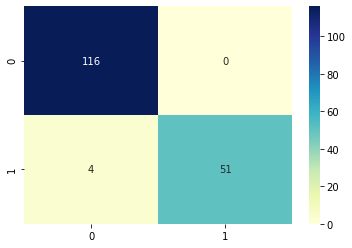

In [21]:
print('CGB:' ,CGB())

# Test XGBoost and LightGBM with a large dataset

In [22]:
credit = pd.read_csv('creditcard.csv')

In [23]:
credit.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [24]:
# brief understanding of the data
print('Rows:', credit.shape[0])
print('Columns:', credit.shape[1])
print('Features:\n', credit.columns.tolist())
print('Missing Values:\n', credit.isnull().sum().values.sum())

Rows: 284807
Columns: 31
Features:
 ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Missing Values:
 0


In [25]:
X = credit.drop(columns=['Time','Class'])
y = credit['Class']

In [26]:
#split the data and change to array format
X_train,X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state = 7)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [27]:
params_xgb ={
    'eta' : 0.01,
    'objective':'binary:logistic',
    'early_stopping_rounds':30,
    'booster': 'gbtree',
    'max_depth': 5
}

In [28]:
params_lgb ={
    'learning_rate'==0.01,
    'objective'== 'binary',
    'early_stopping_rounds'== 30,
    'boosting_type'=='goss',
    'max_depth'== 5
}

In [29]:
# base GBM model
def GBM():
    start = timer()
    model = GradientBoostingClassifier()
    gbm = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = gbm.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    y_pred_prob = model.predict_proba(X_test)[::,1]
    auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy, 'roc_auc_score':auc_roc}

In [30]:
# XGB model with params setting
def XGB():
    start = timer()
    model = XGBClassifier(params = params_xgb)
    xgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    y_pred_prob = xgb.predict_proba(X_test)[::,1]
    auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy, 'roc_auc_score':auc_roc}

In [31]:
# LGB base model
def LGB():
    start = timer()
    model = LGBMClassifier()
    lgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = lgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    y_pred_prob = lgb.predict_proba(X_test)[::,1]
    auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy, 'roc_auc_score':auc_roc}

In [32]:
def LGB2():
    start = timer()
    model = LGBMClassifier(params = params_lgb)
    lgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = lgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    y_pred_prob = lgb.predict_proba(X_test)[::,1]
    auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy, 'roc_auc_score':auc_roc}

{'train_time': 450.3009342959881,
 'accuracy': 0.9989934810341398,
 'roc_auc_score': 0.7589761899718903}

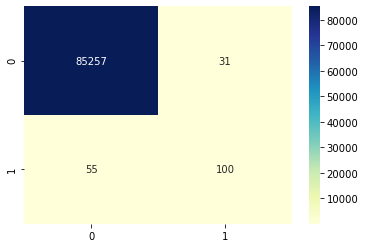

In [33]:
GBM()

{'train_time': 103.19618827799093,
 'accuracy': 0.9995669627705019,
 'roc_auc_score': 0.9886678835429709}

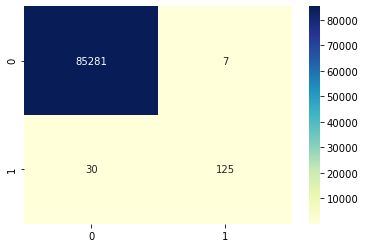

In [34]:
XGB()

{'train_time': 9.055818209390168,
 'accuracy': 0.996278220568098,
 'roc_auc_score': 0.7590695359328998}

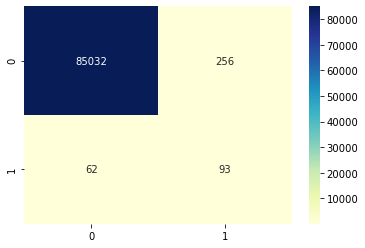

In [35]:
LGB()

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: params keyword has been found in `params` and will be ignored.
Please use params argument of the Dataset constructor to pass this parameter.
  .format(key))


{'train_time': 8.731210112501003,
 'accuracy': 0.996278220568098,
 'roc_auc_score': 0.7590695359328998}

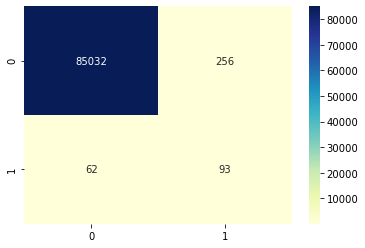

In [36]:
LGB2()

In [37]:
# scale_pos_weight :sum(negative instances) / sum(positive instances)
credit.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [38]:
# XGB model + scale_pos_weight
def XGB():
    start = timer()
    model = XGBClassifier(params = params_xgb, scale_pos_weight= 284315/492)
    xgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    y_pred_prob = xgb.predict_proba(X_test)[::,1]
    auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy, 'roc_auc_score':auc_roc}

{'train_time': 100.73660718187034,
 'accuracy': 0.993516145266435,
 'roc_auc_score': 0.9889118765715254}

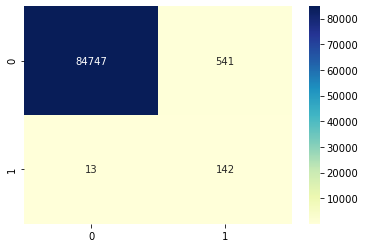

In [39]:
XGB()

In [40]:
# LGB model + scale_pos_weight 
def LGB2():
    start = timer()
    model = LGBMClassifier(params = params_lgb, scale_pos_weight= 284315/492)
    lgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = lgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    y_pred_prob = lgb.predict_proba(X_test)[::,1]
    auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy, 'roc_auc_score':auc_roc}

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: params keyword has been found in `params` and will be ignored.
Please use params argument of the Dataset constructor to pass this parameter.
  .format(key))


{'train_time': 7.2970603732558175,
 'accuracy': 0.9085472186135787,
 'roc_auc_score': 0.8930108535482056}

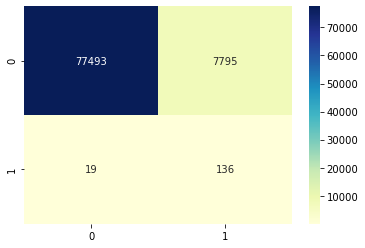

In [41]:
LGB2()

# Test XGBoost and LightGBM with multi-class dataset

In [301]:
iris = pd.read_csv('IRIS.csv')

In [302]:
# brief understanding of the data 
print('Rows:', iris.shape[0])
print('Columns:', iris.shape[1])
print('Features:\n', iris.columns.tolist())
print('Missing Values:\n', iris.isnull().sum().values.sum())

Rows: 150
Columns: 5
Features:
 ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
Missing Values:
 0


In [407]:
# encode = LabelEncoder()
# iris.species = encode.fit_transform(iris.species)
X = iris.drop(columns=['species'])
y = iris['species']


In [408]:
X_train,X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state = 7)
X_train = np.array(X_train)
X_test = np.array(X_test)
lsLabel = set(iris["species"])
labels = list(lsLabel)

In [410]:
def XGB():
    start = timer()
    model = XGBClassifier(params = params_xgb)
    xgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
#     y_pred_prob = lgb.predict_proba(X_test)[::,1]
#     auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy}

In [287]:
def LGB():
    start = timer()
    model = LGBMClassifier(params = params_lgb)
    lgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = lgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
#     y_pred_prob = lgb.predict_proba(X_test)[::,1]
#     auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy}

In [411]:
def CGB():
    start = timer()
    model = CatBoostClassifier()
    cgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = cgb.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
#     y_pred_prob = lgb.predict_proba(X_test)[::,1]
#     auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy}

{'train_time': 0.04798451665556058, 'accuracy': 0.9111111111111111}

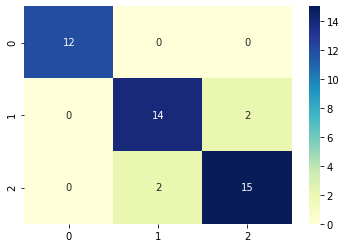

In [288]:
XGB()

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: params keyword has been found in `params` and will be ignored.
Please use params argument of the Dataset constructor to pass this parameter.
  .format(key))


{'train_time': 0.04475419147638604, 'accuracy': 0.8888888888888888}

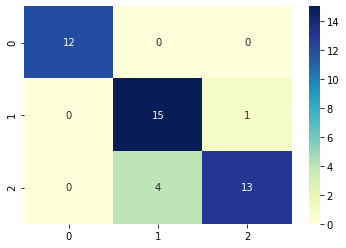

In [289]:
LGB()

0:	learn: 1.0696021	total: 61.1ms	remaining: 1m 1s
1:	learn: 1.0406521	total: 63.1ms	remaining: 31.5s
2:	learn: 1.0116888	total: 64.8ms	remaining: 21.5s
3:	learn: 0.9785021	total: 66.7ms	remaining: 16.6s
4:	learn: 0.9529888	total: 68.3ms	remaining: 13.6s
5:	learn: 0.9228311	total: 69.7ms	remaining: 11.5s
6:	learn: 0.8964538	total: 71.3ms	remaining: 10.1s
7:	learn: 0.8709598	total: 72.7ms	remaining: 9.02s
8:	learn: 0.8445265	total: 74.9ms	remaining: 8.24s
9:	learn: 0.8216122	total: 76.7ms	remaining: 7.59s
10:	learn: 0.8040003	total: 79.2ms	remaining: 7.12s
11:	learn: 0.7842737	total: 81.1ms	remaining: 6.67s
12:	learn: 0.7639594	total: 83.1ms	remaining: 6.31s
13:	learn: 0.7475084	total: 84.7ms	remaining: 5.96s
14:	learn: 0.7259623	total: 86.1ms	remaining: 5.65s
15:	learn: 0.7080438	total: 87.9ms	remaining: 5.41s
16:	learn: 0.6893917	total: 90.6ms	remaining: 5.24s
17:	learn: 0.6725238	total: 91.9ms	remaining: 5.01s
18:	learn: 0.6541894	total: 93.5ms	remaining: 4.83s
19:	learn: 0.6417965	t

160:	learn: 0.0900813	total: 360ms	remaining: 1.88s
161:	learn: 0.0895658	total: 362ms	remaining: 1.87s
162:	learn: 0.0889810	total: 365ms	remaining: 1.87s
163:	learn: 0.0883133	total: 366ms	remaining: 1.87s
164:	learn: 0.0877192	total: 368ms	remaining: 1.86s
165:	learn: 0.0869177	total: 370ms	remaining: 1.86s
166:	learn: 0.0860932	total: 371ms	remaining: 1.85s
167:	learn: 0.0855433	total: 373ms	remaining: 1.85s
168:	learn: 0.0848772	total: 375ms	remaining: 1.84s
169:	learn: 0.0839282	total: 377ms	remaining: 1.84s
170:	learn: 0.0833969	total: 379ms	remaining: 1.84s
171:	learn: 0.0827602	total: 381ms	remaining: 1.83s
172:	learn: 0.0820603	total: 383ms	remaining: 1.83s
173:	learn: 0.0813991	total: 385ms	remaining: 1.83s
174:	learn: 0.0809317	total: 387ms	remaining: 1.82s
175:	learn: 0.0802678	total: 389ms	remaining: 1.82s
176:	learn: 0.0798031	total: 390ms	remaining: 1.81s
177:	learn: 0.0790627	total: 392ms	remaining: 1.81s
178:	learn: 0.0784067	total: 394ms	remaining: 1.81s
179:	learn: 

318:	learn: 0.0347516	total: 650ms	remaining: 1.39s
319:	learn: 0.0345898	total: 652ms	remaining: 1.38s
320:	learn: 0.0344367	total: 653ms	remaining: 1.38s
321:	learn: 0.0343127	total: 655ms	remaining: 1.38s
322:	learn: 0.0341382	total: 661ms	remaining: 1.39s
323:	learn: 0.0340298	total: 663ms	remaining: 1.38s
324:	learn: 0.0338784	total: 664ms	remaining: 1.38s
325:	learn: 0.0337184	total: 667ms	remaining: 1.38s
326:	learn: 0.0335977	total: 669ms	remaining: 1.38s
327:	learn: 0.0334595	total: 671ms	remaining: 1.37s
328:	learn: 0.0333339	total: 673ms	remaining: 1.37s
329:	learn: 0.0332281	total: 675ms	remaining: 1.37s
330:	learn: 0.0331168	total: 676ms	remaining: 1.37s
331:	learn: 0.0329997	total: 678ms	remaining: 1.36s
332:	learn: 0.0328637	total: 680ms	remaining: 1.36s
333:	learn: 0.0327532	total: 682ms	remaining: 1.36s
334:	learn: 0.0326386	total: 685ms	remaining: 1.36s
335:	learn: 0.0325152	total: 686ms	remaining: 1.35s
336:	learn: 0.0323977	total: 688ms	remaining: 1.35s
337:	learn: 

476:	learn: 0.0207030	total: 943ms	remaining: 1.03s
477:	learn: 0.0206375	total: 944ms	remaining: 1.03s
478:	learn: 0.0205777	total: 946ms	remaining: 1.03s
479:	learn: 0.0205155	total: 947ms	remaining: 1.03s
480:	learn: 0.0204608	total: 949ms	remaining: 1.02s
481:	learn: 0.0204147	total: 951ms	remaining: 1.02s
482:	learn: 0.0203716	total: 952ms	remaining: 1.02s
483:	learn: 0.0203100	total: 954ms	remaining: 1.02s
484:	learn: 0.0202615	total: 956ms	remaining: 1.01s
485:	learn: 0.0202058	total: 957ms	remaining: 1.01s
486:	learn: 0.0201581	total: 959ms	remaining: 1.01s
487:	learn: 0.0201065	total: 961ms	remaining: 1.01s
488:	learn: 0.0200582	total: 962ms	remaining: 1s
489:	learn: 0.0200145	total: 964ms	remaining: 1s
490:	learn: 0.0199685	total: 966ms	remaining: 1s
491:	learn: 0.0199260	total: 967ms	remaining: 999ms
492:	learn: 0.0198881	total: 969ms	remaining: 997ms
493:	learn: 0.0198545	total: 971ms	remaining: 994ms
494:	learn: 0.0198188	total: 975ms	remaining: 994ms
495:	learn: 0.0197741

635:	learn: 0.0147908	total: 1.23s	remaining: 703ms
636:	learn: 0.0147661	total: 1.23s	remaining: 701ms
637:	learn: 0.0147376	total: 1.23s	remaining: 699ms
638:	learn: 0.0147168	total: 1.23s	remaining: 697ms
639:	learn: 0.0146920	total: 1.24s	remaining: 695ms
640:	learn: 0.0146619	total: 1.24s	remaining: 693ms
641:	learn: 0.0146385	total: 1.24s	remaining: 691ms
642:	learn: 0.0146038	total: 1.24s	remaining: 689ms
643:	learn: 0.0145734	total: 1.24s	remaining: 687ms
644:	learn: 0.0145513	total: 1.24s	remaining: 684ms
645:	learn: 0.0145261	total: 1.25s	remaining: 682ms
646:	learn: 0.0145009	total: 1.25s	remaining: 681ms
647:	learn: 0.0144759	total: 1.25s	remaining: 679ms
648:	learn: 0.0144421	total: 1.25s	remaining: 679ms
649:	learn: 0.0144177	total: 1.26s	remaining: 677ms
650:	learn: 0.0143892	total: 1.26s	remaining: 675ms
651:	learn: 0.0143652	total: 1.26s	remaining: 673ms
652:	learn: 0.0143293	total: 1.26s	remaining: 670ms
653:	learn: 0.0143057	total: 1.26s	remaining: 668ms
654:	learn: 

793:	learn: 0.0114152	total: 1.52s	remaining: 396ms
794:	learn: 0.0113995	total: 1.53s	remaining: 394ms
795:	learn: 0.0113881	total: 1.53s	remaining: 392ms
796:	learn: 0.0113740	total: 1.53s	remaining: 390ms
797:	learn: 0.0113576	total: 1.53s	remaining: 388ms
798:	learn: 0.0113444	total: 1.53s	remaining: 386ms
799:	learn: 0.0113232	total: 1.54s	remaining: 384ms
800:	learn: 0.0113078	total: 1.54s	remaining: 382ms
801:	learn: 0.0112951	total: 1.54s	remaining: 380ms
802:	learn: 0.0112787	total: 1.54s	remaining: 378ms
803:	learn: 0.0112636	total: 1.54s	remaining: 376ms
804:	learn: 0.0112425	total: 1.54s	remaining: 374ms
805:	learn: 0.0112298	total: 1.55s	remaining: 372ms
806:	learn: 0.0112085	total: 1.55s	remaining: 370ms
807:	learn: 0.0111918	total: 1.55s	remaining: 368ms
808:	learn: 0.0111786	total: 1.55s	remaining: 367ms
809:	learn: 0.0111636	total: 1.55s	remaining: 364ms
810:	learn: 0.0111507	total: 1.55s	remaining: 363ms
811:	learn: 0.0111370	total: 1.56s	remaining: 361ms
812:	learn: 

951:	learn: 0.0093289	total: 1.81s	remaining: 91.6ms
952:	learn: 0.0093161	total: 1.82s	remaining: 89.6ms
953:	learn: 0.0093079	total: 1.82s	remaining: 87.7ms
954:	learn: 0.0092996	total: 1.82s	remaining: 85.8ms
955:	learn: 0.0092893	total: 1.82s	remaining: 83.9ms
956:	learn: 0.0092771	total: 1.82s	remaining: 82ms
957:	learn: 0.0092671	total: 1.83s	remaining: 80.2ms
958:	learn: 0.0092571	total: 1.83s	remaining: 78.3ms
959:	learn: 0.0092413	total: 1.83s	remaining: 76.3ms
960:	learn: 0.0092294	total: 1.83s	remaining: 74.4ms
961:	learn: 0.0092151	total: 1.84s	remaining: 72.5ms
962:	learn: 0.0092039	total: 1.84s	remaining: 70.6ms
963:	learn: 0.0091942	total: 1.84s	remaining: 68.7ms
964:	learn: 0.0091830	total: 1.84s	remaining: 66.8ms
965:	learn: 0.0091720	total: 1.84s	remaining: 64.9ms
966:	learn: 0.0091619	total: 1.84s	remaining: 63ms
967:	learn: 0.0091524	total: 1.85s	remaining: 61ms
968:	learn: 0.0091403	total: 1.85s	remaining: 59.1ms
969:	learn: 0.0091303	total: 1.85s	remaining: 57.2ms

{'train_time': 5.8222750557470135, 'accuracy': 0.9111111111111111}

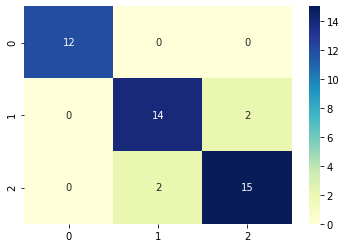

In [412]:
CGB()

In [298]:
# set the logistic regression since other kernel said it has the highest accuracy

def Logit():
    start = timer()
    model = LogisticRegression()
    Logit = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = Logit.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
#     y_pred_prob = model.predict_proba(X_test)[::,1]
#     auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy}

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'train_time': 0.24366028123768046, 'accuracy': 0.9111111111111111}

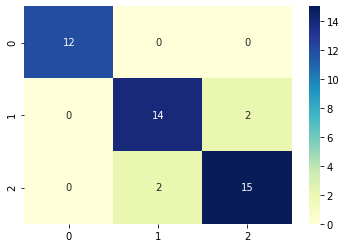

In [294]:
Logit()

In [318]:
def SVM():
    start = timer()
    model = svm.SVC(kernel='rbf', gamma=4, coef0 = 0)
    sv = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = sv.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
#     y_pred_prob = model.predict_proba(X_test)[::,1]
#     auc_roc = roc_auc_score(y_test,y_pred_prob)
    cnf = confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(cnf), annot=True, cmap="YlGnBu" ,fmt='g')

    return {'train_time':run_time, 'accuracy':accuracy}

{'train_time': 0.0027255226159468293, 'accuracy': 0.9111111111111111}

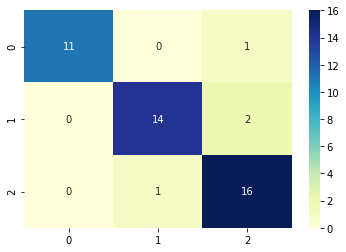

In [319]:
SVM()

# Test XGBoost and LightGBM for price prediction

In [320]:
price = pd.read_csv('avocado.csv')

In [321]:
print('Rows:', price.shape[0])
print('Columns:', price.shape[1])
print('Features:\n', price.columns.tolist())
print('Missing Values:\n', price.isnull().sum().values.sum())

Rows: 18249
Columns: 14
Features:
 ['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region']
Missing Values:
 0


In [336]:
price.head(5)

index        Date  AveragePrice  Total Volume     4046       4225    4770  \
0      0  2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1      1  2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2      2  2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3      3  2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4      4  2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  region  
0     8696.87     8603.62       93.25          0.0  conventional  2015  Albany  
1     9505.56     9408.07       97.49          0.0  conventional  2015  Albany  
2     8145.35     8042.21      103.14          0.0  conventional  2015  Albany  
3     5811.16     5677.40      133.76          0.0  conventional  2015  Albany  
4     6183.95     5986.26      197.69          0.0  conventional  2015  Albany

In [356]:
price = price.rename(columns={'Unnamed: 0':'index'})
price['Date']=price['Date'].str.replace("-","").astype(int)

In [337]:
price.type.unique()

array(['conventional', 'organic'], dtype=object)

In [357]:
le = LabelEncoder()
price['type'] = le.fit_transform(price['type'])
price['region'] = le.fit_transform(price['region'])

In [358]:
X = price.drop(columns=['AveragePrice'])
y = price['AveragePrice']

In [359]:
X_train,X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state = 7)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [393]:
params_xgb ={
    'eta' : 0.01,
    'objective':'reg:squarederror',
    'early_stopping_rounds':30,
    'booster': 'gblinear'
}

params_lgb ={
    'learning_rate'==0.01,
    'objective'== 'regression',
    'early_stopping_rounds'== 30,
}

In [389]:
def XGB():
    start = timer()
    model = XGBClassifier(params = params_xgb)
    xgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = xgb.predict(X_test)
    #accuracy = accuracy_score(y_test, predictions)
    mean_ab_error = mean_absolute_error(y_test, predictions)


    return {'train_time':run_time, 'mean_absolute_error':mean_ab_error}

In [390]:
XGB()

{'train_time': 637.2254714531591, 'mean_absolute_error': 0.16515981735159818}

In [399]:
def XGB():
    start = timer()
    model = XGBRegressor(params = params_xgb)
    xgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = xgb.predict(X_test)
    #accuracy = accuracy_score(y_test, predictions)
    mean_ab_error = mean_absolute_error(y_test, predictions)


    return {'train_time':run_time, 'mean_absolute_error':mean_ab_error}

In [400]:
XGB()

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'train_time': 2.4481227975920774, 'mean_absolute_error': 0.1444407769555915}

In [404]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [402]:
def LGB():
    start = timer()
    model = LGBMRegressor(params = params_lgb)
    lgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = lgb.predict(X_test)
    mean_ab_error = mean_absolute_error(y_test, predictions)


    return {'train_time':run_time, 'mean_absolute_error':mean_ab_error}

In [403]:
LGB()

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: params keyword has been found in `params` and will be ignored.
Please use params argument of the Dataset constructor to pass this parameter.
  .format(key))


{'train_time': 0.6277990968083031, 'mean_absolute_error': 0.09851065254856316}

In [405]:
def CGB():
    start = timer()
    model = CatBoostRegressor()
    cgb = model.fit(X_train, y_train)
    run_time = timer() - start
    predictions = cgb.predict(X_test)
    mean_ab_error = mean_absolute_error(y_test, predictions)


    return {'train_time':run_time, 'mean_absolute_error':mean_ab_error}

In [406]:
CGB()

Learning rate set to 0.061422
0:	learn: 0.3912667	total: 102ms	remaining: 1m 42s
1:	learn: 0.3793151	total: 112ms	remaining: 55.9s
2:	learn: 0.3683935	total: 121ms	remaining: 40.1s
3:	learn: 0.3580342	total: 134ms	remaining: 33.4s
4:	learn: 0.3490880	total: 143ms	remaining: 28.5s
5:	learn: 0.3411913	total: 152ms	remaining: 25.2s
6:	learn: 0.3332803	total: 164ms	remaining: 23.2s
7:	learn: 0.3262209	total: 173ms	remaining: 21.5s
8:	learn: 0.3198338	total: 182ms	remaining: 20.1s
9:	learn: 0.3137770	total: 195ms	remaining: 19.3s
10:	learn: 0.3079314	total: 203ms	remaining: 18.3s
11:	learn: 0.3028315	total: 214ms	remaining: 17.6s
12:	learn: 0.2979380	total: 229ms	remaining: 17.4s
13:	learn: 0.2931700	total: 240ms	remaining: 16.9s
14:	learn: 0.2891203	total: 250ms	remaining: 16.4s
15:	learn: 0.2854746	total: 261ms	remaining: 16.1s
16:	learn: 0.2815546	total: 270ms	remaining: 15.6s
17:	learn: 0.2785287	total: 279ms	remaining: 15.2s
18:	learn: 0.2753601	total: 291ms	remaining: 15s
19:	learn: 0

160:	learn: 0.1700983	total: 1.75s	remaining: 9.1s
161:	learn: 0.1696737	total: 1.76s	remaining: 9.09s
162:	learn: 0.1694106	total: 1.76s	remaining: 9.07s
163:	learn: 0.1690051	total: 1.78s	remaining: 9.07s
164:	learn: 0.1685948	total: 1.79s	remaining: 9.05s
165:	learn: 0.1683185	total: 1.8s	remaining: 9.04s
166:	learn: 0.1679092	total: 1.82s	remaining: 9.09s
167:	learn: 0.1677303	total: 1.83s	remaining: 9.07s
168:	learn: 0.1675606	total: 1.84s	remaining: 9.04s
169:	learn: 0.1671496	total: 1.85s	remaining: 9.06s
170:	learn: 0.1668203	total: 1.88s	remaining: 9.1s
171:	learn: 0.1665234	total: 1.89s	remaining: 9.08s
172:	learn: 0.1662189	total: 1.89s	remaining: 9.05s
173:	learn: 0.1658694	total: 1.9s	remaining: 9.03s
174:	learn: 0.1656631	total: 1.91s	remaining: 9.01s
175:	learn: 0.1654038	total: 1.92s	remaining: 8.99s
176:	learn: 0.1650329	total: 1.93s	remaining: 8.97s
177:	learn: 0.1647390	total: 1.95s	remaining: 9.02s
178:	learn: 0.1644391	total: 1.96s	remaining: 9s
179:	learn: 0.16416

319:	learn: 0.1367396	total: 3.32s	remaining: 7.06s
320:	learn: 0.1364762	total: 3.33s	remaining: 7.05s
321:	learn: 0.1362568	total: 3.34s	remaining: 7.03s
322:	learn: 0.1360701	total: 3.36s	remaining: 7.04s
323:	learn: 0.1359340	total: 3.37s	remaining: 7.02s
324:	learn: 0.1357507	total: 3.38s	remaining: 7.01s
325:	learn: 0.1355585	total: 3.39s	remaining: 7.01s
326:	learn: 0.1354013	total: 3.4s	remaining: 6.99s
327:	learn: 0.1352769	total: 3.4s	remaining: 6.97s
328:	learn: 0.1351686	total: 3.42s	remaining: 6.96s
329:	learn: 0.1350614	total: 3.43s	remaining: 6.97s
330:	learn: 0.1349162	total: 3.44s	remaining: 6.96s
331:	learn: 0.1348484	total: 3.45s	remaining: 6.95s
332:	learn: 0.1346684	total: 3.46s	remaining: 6.93s
333:	learn: 0.1345626	total: 3.47s	remaining: 6.92s
334:	learn: 0.1344629	total: 3.48s	remaining: 6.91s
335:	learn: 0.1344012	total: 3.49s	remaining: 6.89s
336:	learn: 0.1343153	total: 3.5s	remaining: 6.88s
337:	learn: 0.1342447	total: 3.5s	remaining: 6.86s
338:	learn: 0.13

478:	learn: 0.1197059	total: 4.91s	remaining: 5.34s
479:	learn: 0.1196481	total: 4.93s	remaining: 5.34s
480:	learn: 0.1195992	total: 4.93s	remaining: 5.32s
481:	learn: 0.1195245	total: 4.94s	remaining: 5.31s
482:	learn: 0.1194190	total: 4.95s	remaining: 5.3s
483:	learn: 0.1193536	total: 4.96s	remaining: 5.29s
484:	learn: 0.1192430	total: 4.97s	remaining: 5.28s
485:	learn: 0.1191223	total: 4.98s	remaining: 5.27s
486:	learn: 0.1190139	total: 4.99s	remaining: 5.25s
487:	learn: 0.1189518	total: 5s	remaining: 5.24s
488:	learn: 0.1188737	total: 5s	remaining: 5.23s
489:	learn: 0.1188213	total: 5.02s	remaining: 5.22s
490:	learn: 0.1187604	total: 5.03s	remaining: 5.21s
491:	learn: 0.1187246	total: 5.04s	remaining: 5.2s
492:	learn: 0.1186531	total: 5.04s	remaining: 5.19s
493:	learn: 0.1185840	total: 5.06s	remaining: 5.18s
494:	learn: 0.1185321	total: 5.07s	remaining: 5.17s
495:	learn: 0.1184417	total: 5.08s	remaining: 5.16s
496:	learn: 0.1183286	total: 5.08s	remaining: 5.15s
497:	learn: 0.118262

637:	learn: 0.1086779	total: 6.54s	remaining: 3.71s
638:	learn: 0.1085891	total: 6.55s	remaining: 3.7s
639:	learn: 0.1085311	total: 6.55s	remaining: 3.69s
640:	learn: 0.1084987	total: 6.56s	remaining: 3.67s
641:	learn: 0.1084111	total: 6.57s	remaining: 3.67s
642:	learn: 0.1083560	total: 6.58s	remaining: 3.65s
643:	learn: 0.1082942	total: 6.59s	remaining: 3.64s
644:	learn: 0.1082549	total: 6.6s	remaining: 3.63s
645:	learn: 0.1082125	total: 6.61s	remaining: 3.62s
646:	learn: 0.1081705	total: 6.62s	remaining: 3.61s
647:	learn: 0.1081102	total: 6.63s	remaining: 3.6s
648:	learn: 0.1080267	total: 6.64s	remaining: 3.59s
649:	learn: 0.1080108	total: 6.65s	remaining: 3.58s
650:	learn: 0.1079963	total: 6.66s	remaining: 3.57s
651:	learn: 0.1079506	total: 6.67s	remaining: 3.56s
652:	learn: 0.1079184	total: 6.67s	remaining: 3.55s
653:	learn: 0.1078712	total: 6.68s	remaining: 3.54s
654:	learn: 0.1078006	total: 6.69s	remaining: 3.52s
655:	learn: 0.1077692	total: 6.7s	remaining: 3.51s
656:	learn: 0.10

796:	learn: 0.1003273	total: 8.13s	remaining: 2.07s
797:	learn: 0.1002716	total: 8.14s	remaining: 2.06s
798:	learn: 0.1002454	total: 8.15s	remaining: 2.05s
799:	learn: 0.1001771	total: 8.16s	remaining: 2.04s
800:	learn: 0.1001415	total: 8.17s	remaining: 2.03s
801:	learn: 0.1000850	total: 8.18s	remaining: 2.02s
802:	learn: 0.1000409	total: 8.18s	remaining: 2.01s
803:	learn: 0.0999820	total: 8.19s	remaining: 2s
804:	learn: 0.0999304	total: 8.2s	remaining: 1.99s
805:	learn: 0.0998978	total: 8.21s	remaining: 1.98s
806:	learn: 0.0998311	total: 8.22s	remaining: 1.97s
807:	learn: 0.0997908	total: 8.23s	remaining: 1.96s
808:	learn: 0.0997623	total: 8.24s	remaining: 1.95s
809:	learn: 0.0997445	total: 8.25s	remaining: 1.94s
810:	learn: 0.0996994	total: 8.26s	remaining: 1.92s
811:	learn: 0.0996557	total: 8.26s	remaining: 1.91s
812:	learn: 0.0996092	total: 8.28s	remaining: 1.91s
813:	learn: 0.0995751	total: 8.29s	remaining: 1.89s
814:	learn: 0.0994906	total: 8.3s	remaining: 1.88s
815:	learn: 0.099

955:	learn: 0.0936860	total: 9.79s	remaining: 451ms
956:	learn: 0.0936718	total: 9.8s	remaining: 440ms
957:	learn: 0.0936596	total: 9.82s	remaining: 430ms
958:	learn: 0.0936396	total: 9.82s	remaining: 420ms
959:	learn: 0.0935894	total: 9.83s	remaining: 410ms
960:	learn: 0.0935597	total: 9.84s	remaining: 399ms
961:	learn: 0.0935282	total: 9.86s	remaining: 389ms
962:	learn: 0.0935146	total: 9.87s	remaining: 379ms
963:	learn: 0.0934616	total: 9.87s	remaining: 369ms
964:	learn: 0.0934391	total: 9.88s	remaining: 358ms
965:	learn: 0.0934028	total: 9.89s	remaining: 348ms
966:	learn: 0.0933519	total: 9.9s	remaining: 338ms
967:	learn: 0.0933316	total: 9.91s	remaining: 327ms
968:	learn: 0.0932926	total: 9.92s	remaining: 317ms
969:	learn: 0.0932584	total: 9.93s	remaining: 307ms
970:	learn: 0.0932392	total: 9.94s	remaining: 297ms
971:	learn: 0.0932248	total: 9.95s	remaining: 287ms
972:	learn: 0.0931870	total: 9.96s	remaining: 276ms
973:	learn: 0.0931187	total: 9.97s	remaining: 266ms
974:	learn: 0.

{'train_time': 15.059403232939076, 'mean_absolute_error': 0.08294592918877153}

# Shap value 

In [457]:
# select the dataset  breast_cancer.csv
# select model xgboost 

X = cancer.drop(columns=['id','diagnosis'])
y = cancer['diagnosis']
X_train,X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state = 7)
X_train = np.array(X_train)
X_test = np.array(X_test)
params_xgb ={
    'eta' : 0.001,
    'objective':'binary:logistic',
    'early_stopping_rounds':30,
    'booster': 'gbtree',
    'max_depth': 5
}

In [458]:
model = XGBClassifier(params = params_xgb)
xgb = model.fit(X_train, y_train)
predictions = xgb.predict(X_test)

In [459]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

In [463]:
shap_values[0]

array([ 5.4844189e-03, -1.0601318e+00,  9.5736198e-02,  1.1892835e-02,
        6.2699057e-02, -2.1888308e-02,  8.4063299e-03,  6.0954553e-01,
       -1.9375991e-02, -6.0792011e-03,  3.5433000e-01, -7.1401913e-03,
        0.0000000e+00,  6.8293536e-01,  1.5447756e-02, -1.7753281e-01,
       -2.2093017e-02,  3.1012064e-02, -1.0022587e-01,  5.3542573e-03,
        6.1392683e-01, -1.3621794e+00,  1.0633708e+00,  7.6014709e-01,
        2.4477451e-01,  7.0598073e-02,  3.4354997e-01,  1.3816413e+00,
        1.6455296e-01,  1.1449303e-03], dtype=float32)

In [460]:
X_display = X
y_display = y

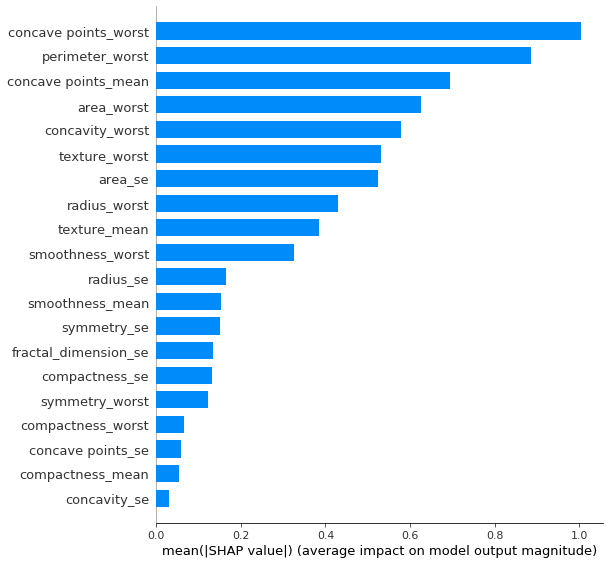

In [461]:
# global interpretability
# the importance of variables
shap.summary_plot(shap_values,X_display,plot_type="bar")

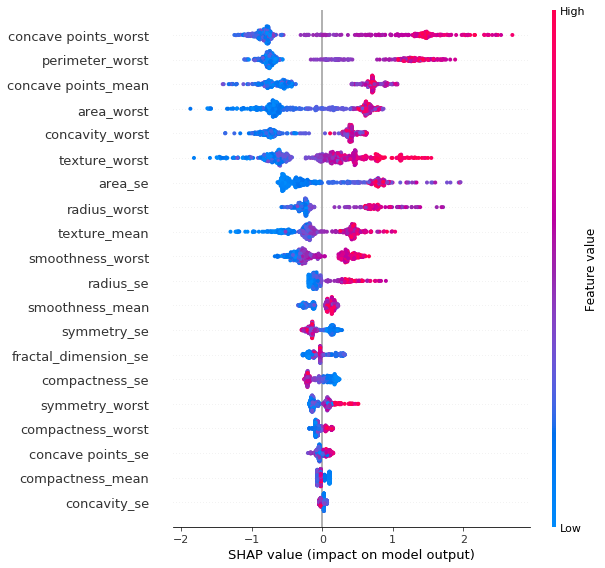

In [47]:
# positive and negative relationships of the predictors with the target variable
shap.summary_plot(shap_values, X)

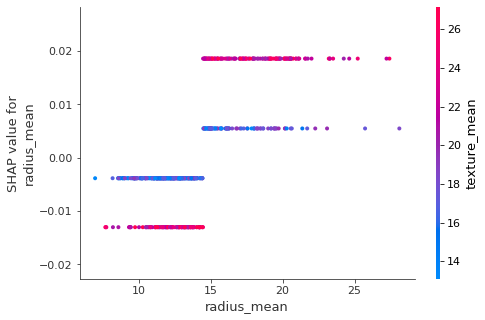

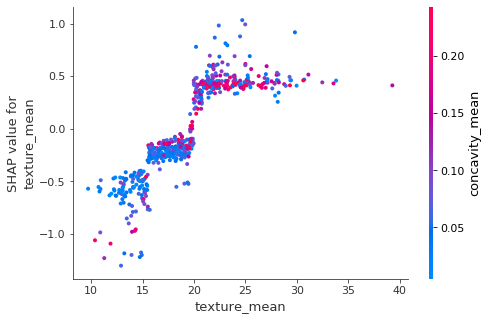

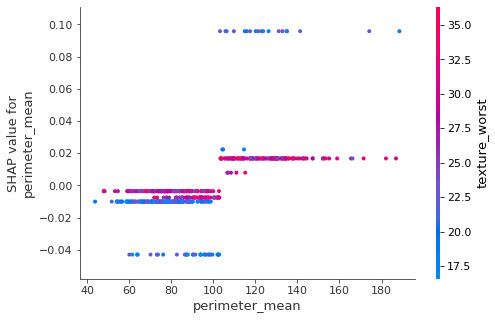

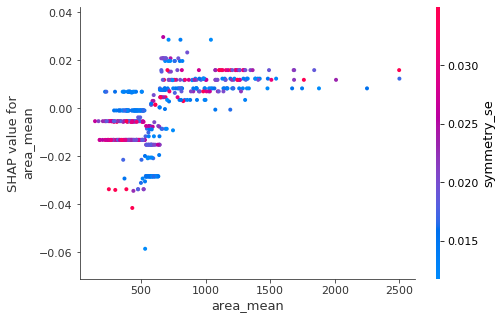

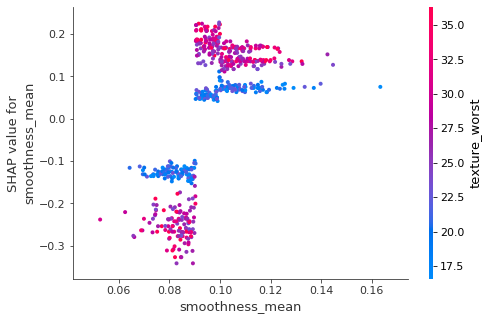

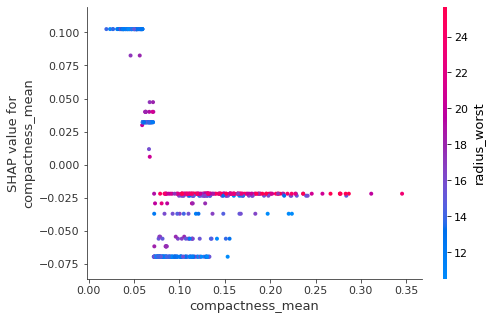

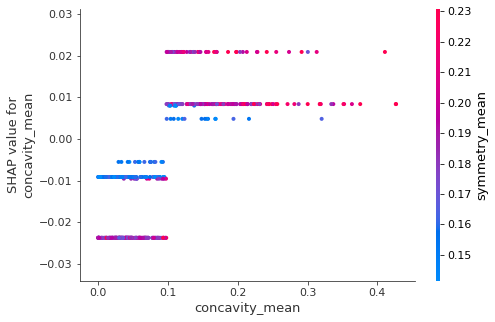

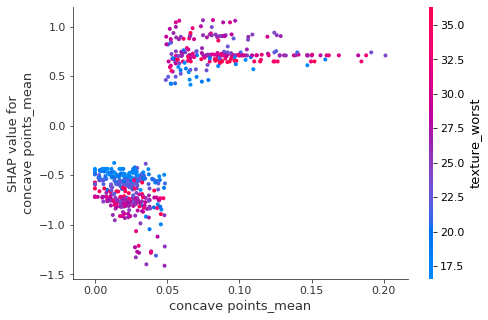

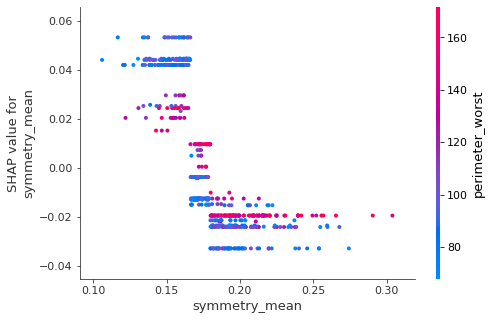

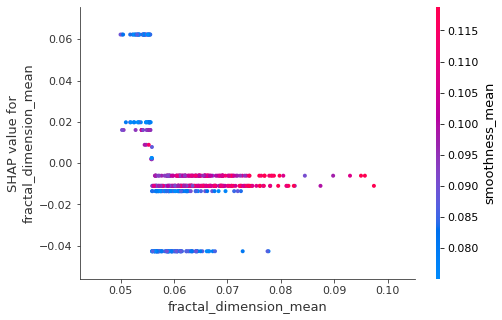

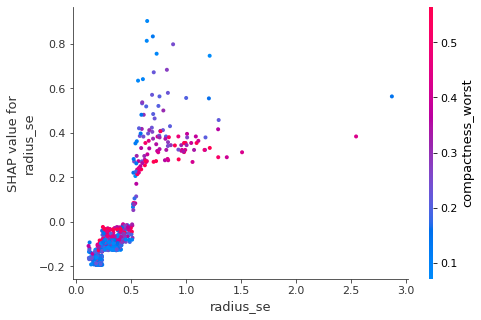

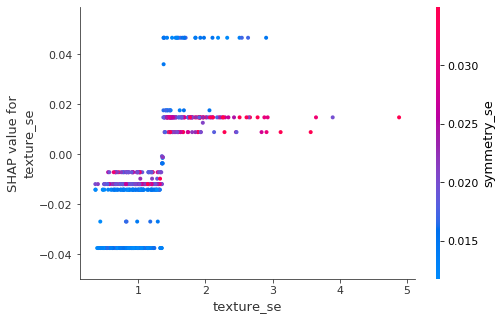

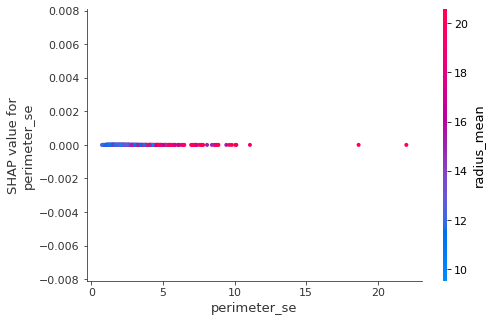

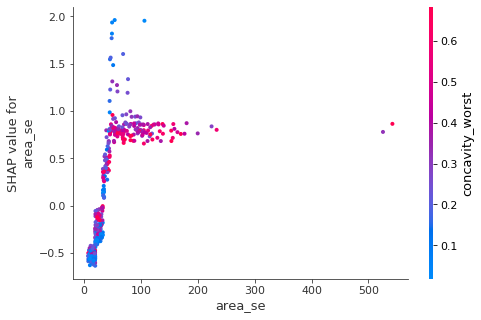

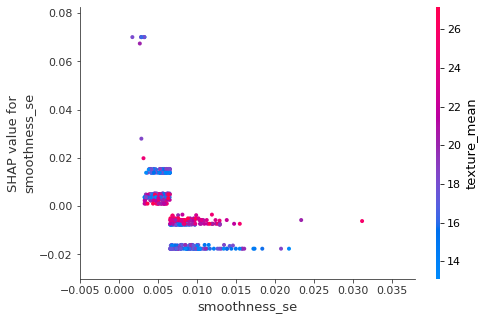

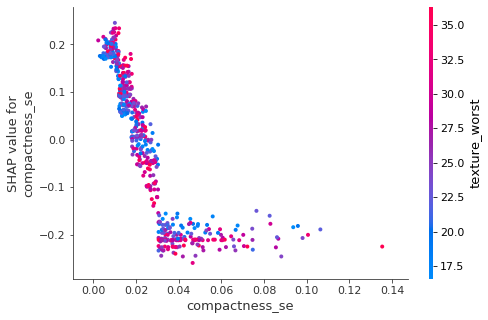

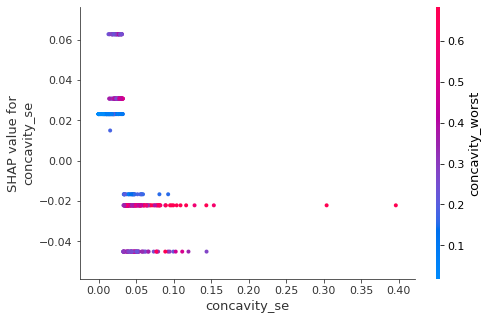

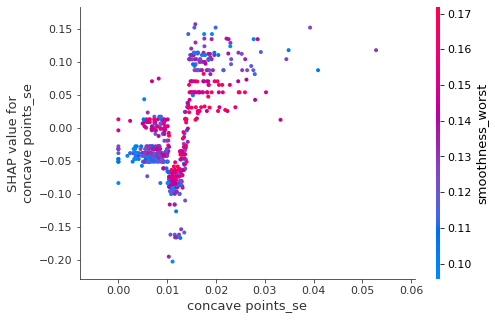

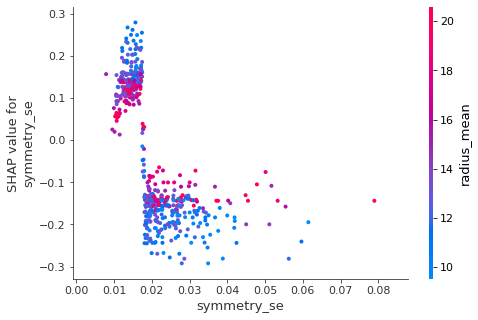

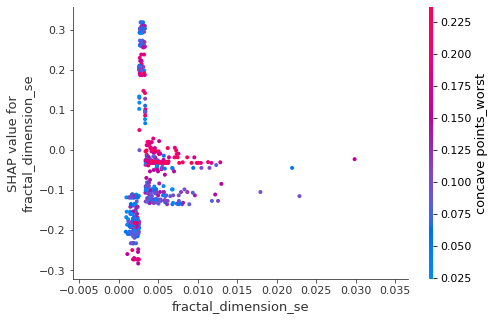

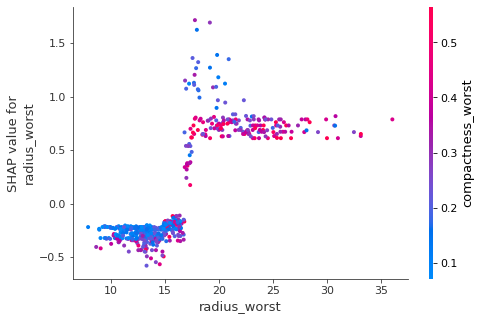

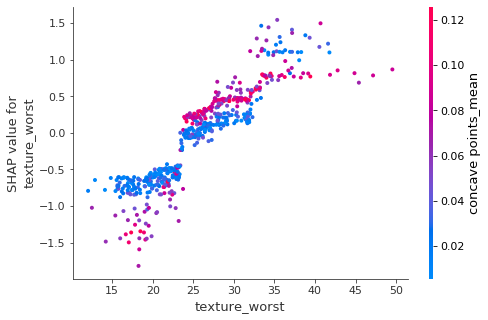

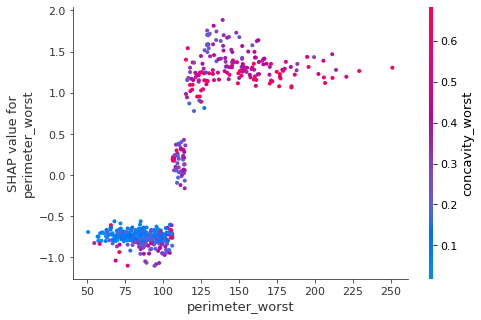

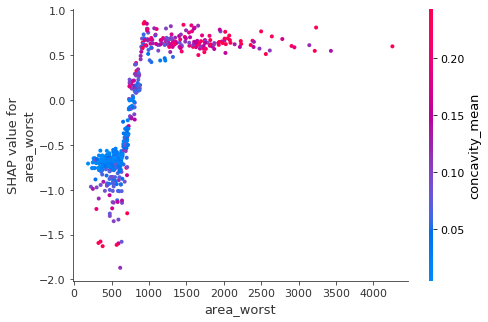

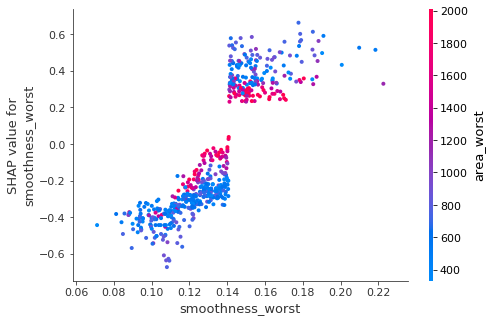

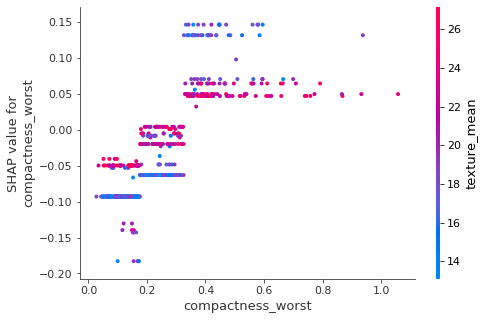

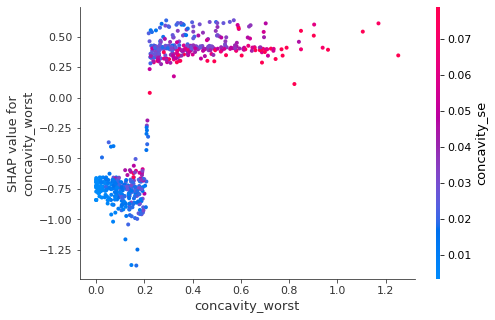

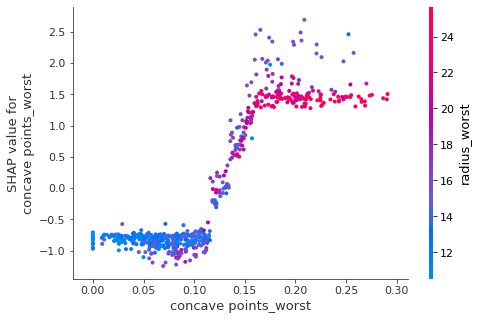

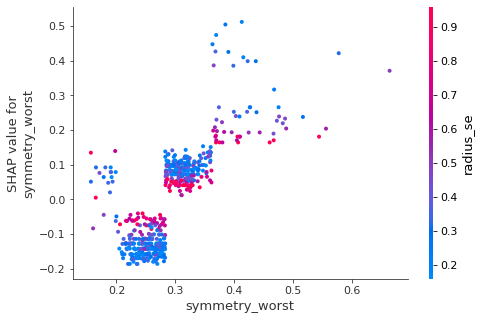

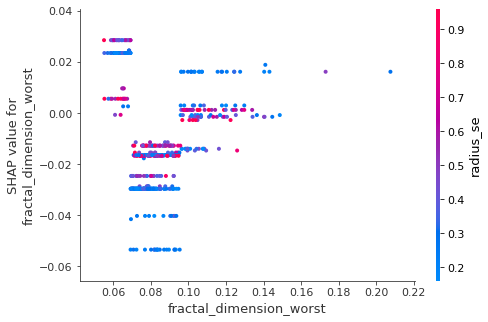

In [48]:
# depedent plot
# relationship between the target and a feature
for name in X.columns:
    shap.dependence_plot(name, shap_values, X)

In [49]:
# local interpretability
# individual force plot
shap.force_plot(explainer.expected_value,shap_values[0,:],X_display.iloc[0,:])

In [50]:
# collective plot
shap.force_plot(explainer.expected_value, shap_values, X)

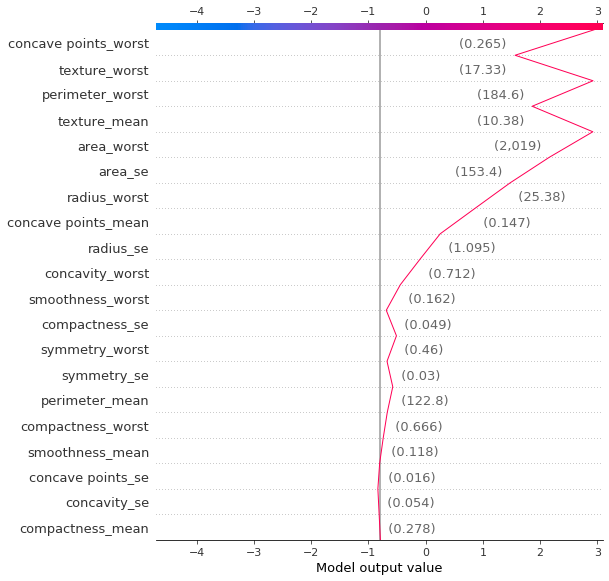

In [51]:
shap.decision_plot(explainer.expected_value,shap_values[0,:], X_display)

In [57]:
# test other explainer

from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
nn = model.fit(X_train, y_train)
predictions = nn.predict(X_test)

In [63]:
explainer = shap.KernelExplainer(nn.predict, X_test)
shap_values = explainer.shap_values(X_test)

Using 171 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

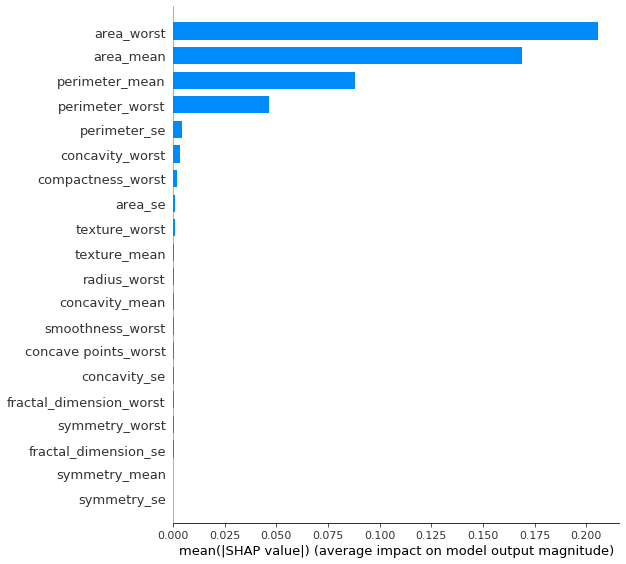

In [64]:
shap.summary_plot(shap_values, X_display,plot_type='bar')

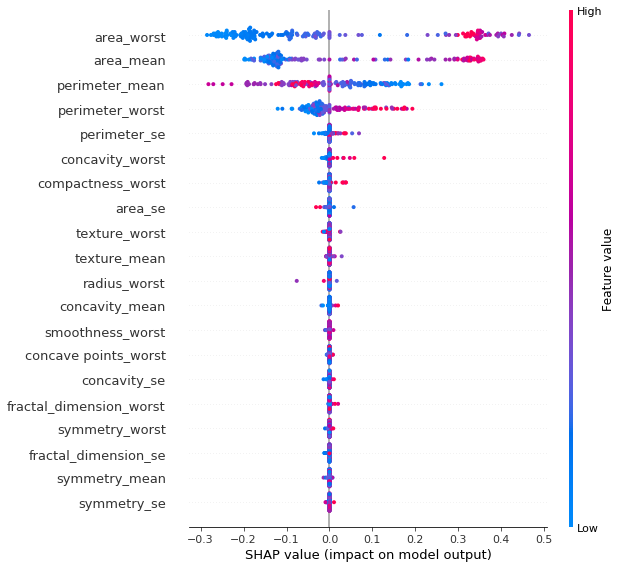

In [75]:
shap.summary_plot(shap_values, X_test, X_display.columns)

In [81]:
shap.force_plot(explainer.expected_value,shap_values[0,:],X_test[0,:],X_display.columns)

In [87]:
explainer = shap.KernelExplainer(nn.predict, X_train)
shap_values = explainer.shap_values(X_test)

Using 398 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
C:\Users\P1320217\AppData\Local\Continuum\anaconda3\lib\site-packages\shap\explainers\kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

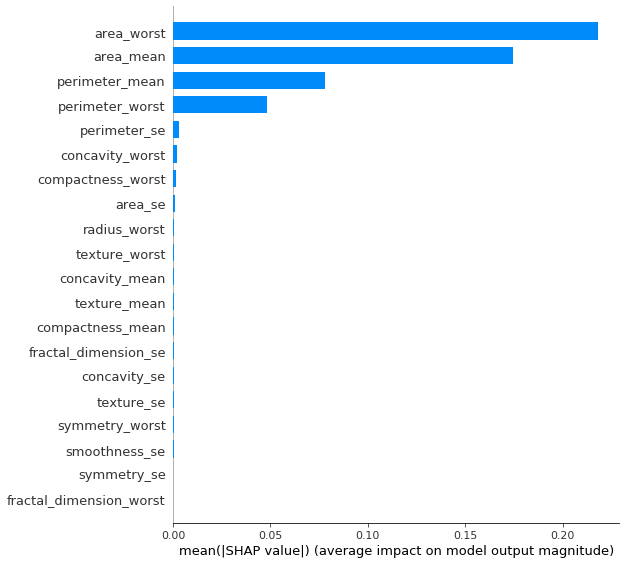

In [88]:
shap.summary_plot(shap_values, X_display,plot_type='bar')

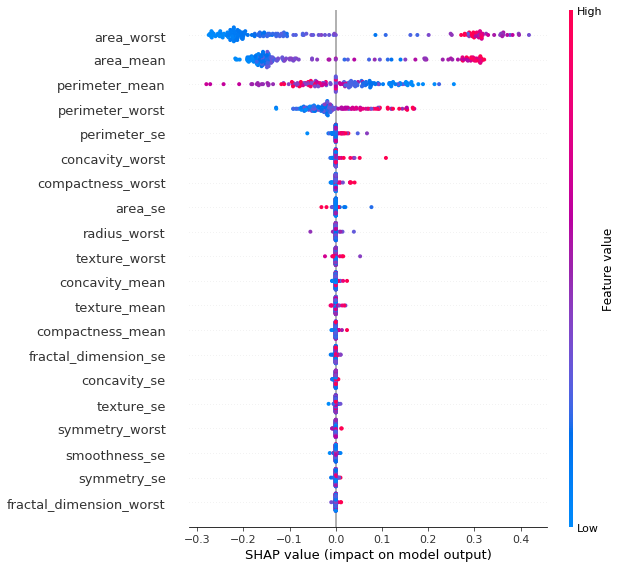

In [89]:
shap.summary_plot(shap_values, X_test, X_display.columns)

In [90]:
shap.force_plot(explainer.expected_value,shap_values[0,:],X_test[0,:],X_display.columns)

In [91]:
model = XGBClassifier(params = params_xgb)
xgb = model.fit(X_train, y_train)
predictions = xgb.predict(X_test)

In [97]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

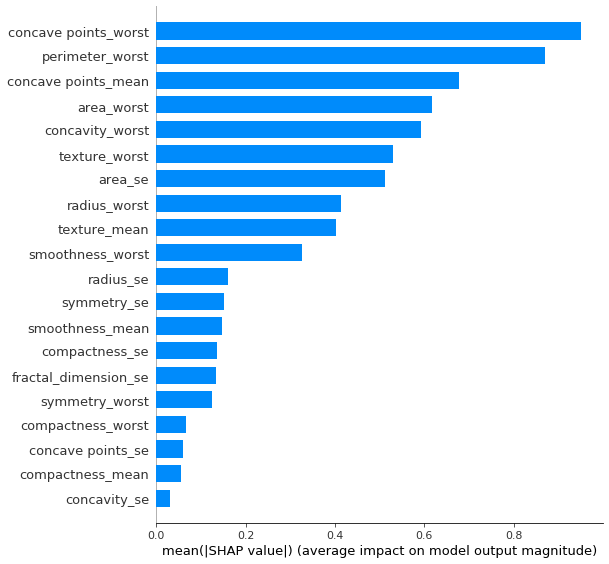

In [95]:
shap.summary_plot(shap_values, X_display,plot_type='bar')

In [98]:
shap.force_plot(explainer.expected_value,shap_values[0,:],X_test[0,:],X_display.columns)

# How to Deploy AutoML as a Rest API
- References: 
    - https://github.com/crawles/automl_service
    - https://towardsdatascience.com/deploy-your-machine-learning-model-as-a-rest-api-4fe96bf8ddcc
    - https://www.kdnuggets.com/2019/01/build-api-machine-learning-model-using-flask.html
    - https://www.datacamp.com/community/tutorials/machine-learning-models-api-python
    - https://tanzu.vmware.com/content/blog/automated-machine-learning-deploying-automl-to-the-cloud

# View All Packages Used 

In [148]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
print(list(imports()))

print("\n\n")

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

['builtins', 'builtins', 'json', 'numpy', 'pandas', 'scipy', 'seaborn', 'matplotlib.pyplot', 'sklearn.svm', 'shap', 'joblib', 'ipywidgets.widgets', 'plotly.graph_objs', 'plotly_express', 'cufflinks', 'pickle', 'h2o', 'types', 'pkg_resources']



xgboost==0.90
shap==0.34.0
seaborn==0.9.0
scipy==1.1.0
scikit-learn==0.20.1
plotly==4.5.4
pandas==1.0.2
numpy==1.18.1
matplotlib==3.0.2
lightgbm==2.3.1
joblib==0.14.1
ipywidgets==7.4.2
h2o==3.28.0.3
